<a href="https://colab.research.google.com/github/TitusChoi/Novelist_Classification/blob/master/Novelist_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Novelist_Classification.ipynb
Description   : 소설 작가 분류에 대한 예측 모델 구현<br>
Date : 2021.04.23 ~ 2021.04.29<br>
Author : 최유리, 정석영, 박민춘, 최디도

# 1. 필요 라이브러리 정의 및 데이터 목록 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install attention

In [ ]:
import pandas as pd
import warnings 
warnings.filterwarnings(action='ignore')
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import seaborn as sns
import re
import random
from keras.layers import LSTM, Bidirectional, Dropout
from attention import Attention
from keras.optimizers import Adam,Nadam
import nltk

In [ ]:
#경로 재설정
import os
os.chdir('./')

In [ ]:
#파일 불러오기
train = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/train.csv', encoding = 'utf-8')
train_new = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/new_train.csv', encoding = 'utf-8')
test = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/test_x.csv', encoding = 'utf-8')
test_new = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/new_test.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/sample_submission.csv', encoding = 'utf-8')
sample_submission_new = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/new_sample_submission.csv', encoding = 'utf-8')

In [ ]:
#train 데이터 살펴보기
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [ ]:
train_new

,Unnamed: 0,text,author
0,0,It is hard to forget repulsive things. I remem...,6
1,1,It would be tedious if given in the beadle’s w...,7
2,2,“Very good. Shall we argue about it here in p...,2
3,3,“What! and I as high as a tree and as big as a...,6
4,4,"""Isn't it enough, Vanya?"" she cried, seeing hi...",3
...,...,...,...
83215,83215,"What with the birthday visitors, and what with...",7
83216,83216,It was an old rickety door and gave at once be...,2
83217,83217,"“Well then you can go to the devil,” said odin...",3
83218,83218,“Don’t know?”,7


In [ ]:
#test 데이터 살펴보기
del test_new['Unnamed: 0']
test_new

,index,text
0,0,"About thirty years ago Miss Maria Ward, of Hun..."
1,1,"Their homes were so distant, and the circles i..."
2,2,The letter was not unproductive. It re-establi...
3,3,"Such were its immediate effects, and within a ..."
4,4,Sir Thomas could not give so instantaneous and...
...,...,...
27313,27313,"At the end of another day or two, odin growing..."
27314,27314,"All afternoon we sat together, mostly in silen..."
27315,27315,"odin, having carried his thanks to odin, proc..."
27316,27316,"Soon after this, upon odin's leaving the room,..."


In [ ]:
#sample_submission
del sample_submission_new['Unnamed: 0']
sample_submission_new = sample_submission_new.drop(sample_submission_new.index[27318])
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
27313,27313,0,0,0,0,0,0,0,0
27314,27314,0,0,0,0,0,0,0,0
27315,27315,0,0,0,0,0,0,0,0
27316,27316,0,0,0,0,0,0,0,0


# 2. 데이터 전처리

## 2.1. 문장 부호를 제거

In [ ]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

train['text']=train['text'].apply(alpha_num)

NameError: ignored

## 2.2. 불용어 처리전 데이터 분리

In [ ]:
# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in base_stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
base_stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [ ]:
#전처리 직접 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)


train_new['text'] = train_new['text'].str.lower()
test_new['text'] = test_new['text'].str.lower()
train_new['text'] = train_new['text'].apply(alpha_num).apply(remove_stopwords)
test_new['text'] = test_new['text'].apply(alpha_num).apply(remove_stopwords)

NameError: ignored

In [ ]:
# train test 분리
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
y_train = np.array([x for x in train['author']])

X_train_new = np.array([x for x in train_new['text']])
X_test_new = np.array([x for x in test_new['text']])
y_train_new = np.array([x for x in train_new['author']])

## 2.3. nltk 라이브러리 활용 불용어 제거

In [ ]:
# nltk 라이브러리를 사용한 불용어 제거
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

nltk_stopword = set(stopwords.words('english'))

# Stopword 만 제거한 결과
def remove_stopwords_nltk(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in nltk_stopword:
            final_text.append(i.strip())
    return " ".join(final_text)

In [ ]:
# 단어 길이 확인
tmp = train

for i in range(len(tmp['text'])):
    tmp['text'][i] = tmp['text'][i].strip().split()

vocab = nltk.FreqDist(np.hstack(tmp['text']))
print('단어 집합의 크기 : {}'.format(len(vocab)))

## 2.4. 작가별 텍스트 시각화

In [ ]:
# 작가별 text 나누는 함수 정의
author_0 = train.loc[train['author'] == 0, 'text']
author_1 = train.loc[train['author'] == 1, 'text']
author_2 = train.loc[train['author'] == 2, 'text']
author_3 = train.loc[train['author'] == 3, 'text']
author_4 = train.loc[train['author'] == 4, 'text']
author_5 = train.loc[train['author'] == 5, 'text']
author_6 = train.loc[train['author'] == 6, 'text']
author_7 = train.loc[train['author'] == 7, 'text']

print(author_0.shape)
print(author_1.shape)
print(author_2.shape)
print(author_3.shape)
print(author_4.shape)
print(author_5.shape)
print(author_6.shape)
print(author_7.shape)

In [ ]:
# 작가별 text길이 시각화
sns.set_palette("Paired")
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train,)
plt.show()

In [ ]:
# keras 문장 토큰화
## text_to_word_sequence는 알파벳을 소문자로 바꾸고, Punctuation을 제거한다
from tensorflow.keras.preprocessing.text import text_to_word_sequence


# 시리즈를 리스트로, 리스트를 문자열로 바꾸는 함수 (text_to_word_sequence가 문자열만 입력값으로 받기 때문)
def series_list_to_str(a):
    a.to_list()
    return " ".join([str(_) for _ in a])


str_author_0 = series_list_to_str(author_0)
str_author_1 = series_list_to_str(author_1)
str_author_2 = series_list_to_str(author_2)
str_author_3 = series_list_to_str(author_3)
str_author_4 = series_list_to_str(author_4)
str_author_5 = series_list_to_str(author_5)
str_author_6 = series_list_to_str(author_6)
str_author_7 = series_list_to_str(author_7)

In [ ]:
# 문장을 단어로 바꿔주는 함수
author_word_0 = text_to_word_sequence(str_author_0)
author_word_1 = text_to_word_sequence(str_author_1)
author_word_2 = text_to_word_sequence(str_author_2)
author_word_3 = text_to_word_sequence(str_author_3)
author_word_4 = text_to_word_sequence(str_author_4)
author_word_5 = text_to_word_sequence(str_author_5)
author_word_6 = text_to_word_sequence(str_author_6)
author_word_7 = text_to_word_sequence(str_author_7)
print(author_word_0[:20])

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer()

# fit_on_texts 적용 함수
# fit_on_texts()는 입력한 텍스트로부터 단어 빈도수가 높은 순으로 낮은 정수 인덱스를 부여


def fitontexts(words):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts([words])
    return tokenizer.word_index


# 이 과정으로 작가별 빈도수가 높은 단어를 구할 수 있음.
author0_index = fitontexts(author_word_0)
author1_index = fitontexts(author_word_1)
author2_index = fitontexts(author_word_2)
author3_index = fitontexts(author_word_3)
author4_index = fitontexts(author_word_4)
author5_index = fitontexts(author_word_5)
author6_index = fitontexts(author_word_6)
author7_index = fitontexts(author_word_7)



# print(author0_index)
# print(author1_index)
# print(author2_index)
# print(author3_index)
# print(author4_index)
# print(author5_index)
# print(author6_index)
# print(author7_index)

In [ ]:
# 상위 30개 많이 쓰인 단어
import seaborn as sns
from collections import Counter

fig = plt.figure(figsize=(17, 8))
rows = 2
cols = 4


def plot_top_non_stopwords_barchart(text):

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        x.append(word)
        y.append(count)

    return x, y


for i in range(8):
    x, y = plot_top_non_stopwords_barchart(
        train[train['author'] == i]['text'])
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(i)
    sns.barplot(x=y, y=x)

In [ ]:
# 작가별 많이 쓴 단어 상위 10개
fig = plt.figure(figsize=(17, 8))  # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 4


def plot_top_non_stopwords_barchart2(text):

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:10]:
        x.append(word)
        y.append(count)
    return x, y


for i in range(8):
    x, y = plot_top_non_stopwords_barchart2(
        train[train['author'] == i]['text'])
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(i)
    sns.barplot(x=y, y=x)

### 2.4.1. N-gram 시각화

In [ ]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    stop=set(base_stopwords)

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(train['text'], n=3)    

In [ ]:
fig = plt.figure(figsize=(16,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 4

def plot_top_ngrams_barchart2(text, n=2):
    stop=set(base_stopwords)

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    
    return x, y

for i in range(8):
    x,y = plot_top_ngrams_barchart2(train[train['author']==i]['text'], n=3)
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)
    plt.tight_layout()

### 2.4.2. 토픽별 EDA

In [ ]:
!pip install pyLDAvis=='2.1.2'

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
# With NLTK you can tokenize and lemmatize easily:

import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim

NUM_TOPICS = 8


def get_lda_objects(text):
    nltk.download('stopwords')
    stop = set(base_stopwords)

    def _preprocess_text(text):
        corpus = []
        stem = PorterStemmer()
        lem = WordNetLemmatizer()
        for news in text:
            words = [w for w in word_tokenize(news) if (w not in stop)]

            words = [lem.lemmatize(w) for w in words if len(w) > 2]

            corpus.append(words)
        return corpus

    corpus = _preprocess_text(text)

    dic = gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]

    lda_model = gensim.models.LdaMulticore(bow_corpus,
                                           num_topics=NUM_TOPICS,
                                           id2word=dic,
                                           passes=10,
                                           workers=2)

    return lda_model, bow_corpus, dic


def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [ ]:
lda_model, bow_corpus, dic = get_lda_objects(train['text'])

In [ ]:
lda_model.show_topics()

In [ ]:
plot_lda_vis(lda_model, bow_corpus, dic)

### 2.4.3. 훈련 데이터 LDA

In [ ]:
lda_model, bow_corpus, dic = get_lda_objects(test['text'])

In [ ]:
plot_lda_vis(lda_model, bow_corpus, dic)

### 2.4.4. 감정 분석(Sentiment Analysis)

In [ ]:
from textblob import TextBlob
    
def plot_polarity_histogram(text):
    
    def _polarity(text):
        return TextBlob(text).sentiment.polarity
        
    polarity_score = text.apply(lambda x : _polarity(x))
    return polarity_score

In [ ]:
fig = plt.figure(figsize=(10,5)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 4

for i in range(8):
    polarity_score = plot_polarity_histogram(train[train['author']==i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    polarity_score.hist()
    plt.tight_layout()

### 2.4.5. 평가 자료 극성 분석(Test Data Polarity)

In [ ]:
polarity_score = plot_polarity_histogram(test['text'])
polarity_score.hist()

In [ ]:
def sentiment_vader(text, sid):
    ss = sid.polarity_scores(text)
    ss.pop('compound')
    return max(ss, key=ss.get)

def sentiment_textblob(text):
        x = TextBlob(text).sentiment.polarity
        
        if x<0:
            return 'neg'
        elif x==0:
            return 'neu'
        else:
            return 'pos'

def plot_sentiment_barchart(text, method='TextBlob'):
    if method == 'TextBlob':
        sentiment = text.map(lambda x: sentiment_textblob(x))
    elif method == 'Vader':
        nltk.download('vader_lexicon')
        sid = SentimentIntensityAnalyzer()
        sentiment = text.map(lambda x: sentiment_vader(x, sid=sid))
    else:
        raise ValueError('Textblob or Vader')
    
    return sentiment

In [ ]:
fig = plt.figure(figsize=(10,5)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 4

for i in range(8):
    sentiment = plot_sentiment_barchart(train[train['author']==i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    #plt.bar(sentiment.value_counts().index, sentiment.value_counts())
    ax.set_title(i)
    sns.barplot(sentiment.value_counts().index, sentiment.value_counts())
    plt.tight_layout()

### 2.4.6. 평가 데이터 감정 분석(Test Data Sentiment Analysis)

In [ ]:
sentiment = plot_sentiment_barchart(test['text'])
sns.barplot(sentiment.value_counts().index, sentiment.value_counts())

### 2.4.7 개체명인식(NER : Named Entity Recognition)

In [ ]:
import spacy
from collections import  Counter
import seaborn as sns

def plot_named_entity_barchart(text):
    nlp = spacy.load("en_core_web_sm")
    
    def _get_ner(text):
        doc=nlp(text)
        return [X.label_ for X in doc.ents]
    
    ent=text.apply(lambda x : _get_ner(x))
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    count=counter.most_common()
    
    x,y=map(list,zip(*count))
    return x,y

In [ ]:
fig = plt.figure(figsize=(20,20)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 4

for i in range(8):
    x, y = plot_named_entity_barchart(train[train['author']==i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)

### 2.4.8 사람 이름 분포

In [ ]:
import spacy
from collections import Counter
import seaborn as sns


def plot_most_common_named_entity_barchart(text, entity="PERSON"):
    nlp = spacy.load("en_core_web_sm")

    def _get_ner(text, ent):
        doc = nlp(text)
        return [X.text for X in doc.ents if X.label_ == ent]

    entity_filtered = text.apply(lambda x: _get_ner(x, entity))
    entity_filtered = [i for x in entity_filtered for i in x]

    counter = Counter(entity_filtered)
    x, y = map(list, zip(*counter.most_common(10)))
    return x, y

In [ ]:
fig = plt.figure(figsize=(20, 15))  # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 4

for i in range(8):
    x, y = plot_most_common_named_entity_barchart(
        train[train['author'] == i]['text'], entity="PERSON")
    ax = fig.add_subplot(rows, cols, i + 1)
    sns.barplot(y, x).set_title(i)

# 3. 데이터 임베딩

## 3.1. 임베딩에 필요한 라이브러리 및 사전 학습 데이터 가져오기

In [ ]:
import gensim
from gensim.models.keyedvectors import KeyedVectors

In [ ]:
pip install -U gensim

In [ ]:
FastText = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Novelist_Classification/Embedding/fasttext.vec')

In [ ]:
Word2Vec_model = gensim.models.KeyedVectors.load_word2vec_format(
    '/content/drive/MyDrive/Novelist_Classification/Embedding/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
#파라미터 설정
vocab_size = 63727
embedding_dim = 16
max_length = 212
padding_type='post'

In [ ]:
#tokenizer에 fit
tokenizer = Tokenizer(num_words = vocab_size) #, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [ ]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
# len(train_sequences)
idx = []
for i in range(len(train_sequences)):
    if len(train_sequences[i]) > 213 :
        idx.append(i)

# len(idx)
# type(X_train)
# X_train = np.delete(X_train,idx,0)
# y_train = np.delete(y_train, idx)

train = train.drop(idx)

In [ ]:
tmp = train

vocab = nltk.FreqDist(np.hstack(tmp['text']))
print('단어 집합의 크기 : {}'.format(len(vocab)))

In [ ]:
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
y_train = np.array([x for x in train['author']])

In [ ]:
#단어 집합 크기에 따른 단어파라미터 재설정
vocab_size = 63162

In [ ]:
#tokenizer에 fit
tokenizer = Tokenizer(num_words = vocab_size) #, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [ ]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)

# train_sequences
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

# train_padded
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

## 3.2. Word2Vec

In [ ]:
# Word2Vec 임베딩 과정
W2V_embedding_matrix = np.zeros((vocab_size,300))

def get_vector(word):
    if word in Word2Vec_model:
        return Word2Vec_model[word]
    else:
        return None

In [ ]:
# print(vocab.items())
for idx, word in word_index.items():

    temp = get_vector(word)
    if temp is not None:
        W2V_embedding_matrix[idx] = temp
        
print(W2V_embedding_matrix.shape)

In [ ]:
vocab.items()

In [ ]:
word_index.items()

## 3.3. Fasttext

In [ ]:
# Fasttext 임베딩 과정
FT_embedding_matrix = np.zeros((vocab_size,100))

def get_vector(word):
    if word in FastText:
        return FastText[word]
    else:
        return None

for word, idx in word_index.items():
    temp = get_vector(word)
    if temp is not None:
        FT_embedding_matrix[idx] = temp

## 3.4. Glove
Glove 임베딩은 아래의 두 가지 장점을 섞은 [스탠포드](https://nlp.stanford.edu/projects/glove/)에서 개발한 NLP 임베딩 기법이다.
1. 예측 기반 기법
Word2Vec에 사용되는 기법
2. 카운트 기반 기법
LSA에 사용되는 기법

Word2Vec은 실제값과 예측값에 대한 오차를 손실 함수를 통해 줄여나가며 학습하는 예측 기반 기법이다. 이와 반대로 LSA는 문서에서 각 단어의 빈도수를 세어 전체적인 통계 정보를 입력으로 받아 차원을 축소시켜가며 잠재된 의미를 끌어내는 방법론이었다.<br>
<br>
우선 Word2Vec의 경우 단어간 유추 작업에는 상당한 성능을 보이지만, 임베딩 벡터가 한정된 크기 내에서 주변 단어를 고려하기 때문에 전체적인 통계 흐름을 반영하지 못한다.<br>
<br>
반면 LSA의 경우 카운트 기반으로 전체 통계 정보를 고려하지만 왕:남자 = 여왕 : X와 같은 단어를 찾는 유추 방식에서 성능이 떨어진다.<br>
<br>
이러한 점을 보완하기 위해 윈도우 기반 동시 등장 행렬과 동시 등장 확률 매커니즘을 활용한다. 그러나 Glove 임베딩이 절대적인 것은 아니다. Word2Vec과 성능 비교 후 더 효과적인 것을 활용하면 된다.

In [ ]:
# Glove 임베딩 과정
embedding_dict= dict()
f = open('/content/drive/MyDrive/Novelist_Classification/Embedding/glove.txt', encoding='utf8')

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close

glove_embedding_matrix = np.zeros((vocab_size+1, 50))

for word, i in word_index.items():
    temp = embedding_dict.get(word)
    if temp is not None:
        glove_embedding_matrix[i] = temp

# 4. 모델 구축

## 4.1. Simple DNN

In [ ]:
# 간단한 DNN 모델
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [ ]:
# compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model.summary())

In [ ]:
# fit model
num_epochs = 20
history = model.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2)

결과에 따라 우리는 소설 작가 예측 모델을 Fasttext 임베딩과 Glove 임베딩만을 적용해보기로 했다.

## 4.2. CNN(Convolution Neural Network)

### 4.2.1. General CNN
임베딩 과정에서 임베딩을 겹치는 변수가 존재해서 임베딩 과정을 다시 정의했다.

In [ ]:
#파라미터 설정
vocab_size = 47136
vocab_size_new = 63727
embedding_dim = 16
max_length = 500
padding_type='post'
#oov_tok = "<OOV>"

In [ ]:
#tokenizer에 fit
# 작가 5명
tokenizer = Tokenizer(num_words = vocab_size)#, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# 작가 8명
tokenizer_new = Tokenizer(num_words = vocab_size_new)#, oov_token=oov_tok)
tokenizer_new.fit_on_texts(X_train_new)
word_index_new = tokenizer_new.word_index

In [ ]:
# Fasttext 임베딩 과정
FT_embedding_matrix = np.zeros((vocab_size,100))
FT_embedding_matrix_new = np.zeros((vocab_size_new,100))

def get_vector(word):
    if word in FastText:
        return FastText[word]
    else:
        return None

# 작가5명
for word, idx in word_index.items():
    temp = get_vector(word)
    if temp is not None:
        FT_embedding_matrix[idx] = temp

# 작가8명
for word, idx in word_index_new.items():
    temp = get_vector(word)
    if temp is not None:
        FT_embedding_matrix_new[idx] = temp

In [ ]:
# 사전 학습된 glove 불러오고 임베딩 층에 적용시키기 
embedding_dict= dict()
f = open('/content/drive/MyDrive/Novelist_Classification/embbeding/glove.txt', encoding='utf8')

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close

g_embedding_matrix = np.zeros((vocab_size, 50))
g_embedding_matrix_new = np.zeros((vocab_size_new+1, 50))

# 작가5명
for word, i in word_index.items():
    temp = embedding_dict.get(word)
    if temp is not None:
        g_embedding_matrix[i] = temp

# 작가8명
for word, i in word_index_new.items():
    temp = embedding_dict.get(word)
    if temp is not None:
        g_embedding_matrix_new[i] = temp

구성된 CNN 모델의 설계도는 아래와 같다.

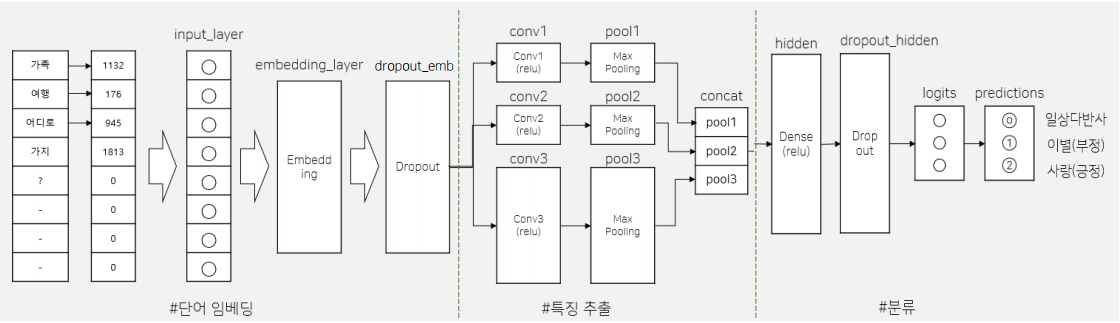

In [ ]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

train_sequences_new = tokenizer.texts_to_sequences(X_train_new)
train_padded_new = pad_sequences(train_sequences_new, padding=padding_type, maxlen=max_length)

test_sequences_new = tokenizer.texts_to_sequences(X_test_new)
test_padded_new = pad_sequences(test_sequences_new, padding=padding_type, maxlen=max_length)

In [ ]:
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dropout,Dense, Conv1D, GlobalMaxPool1D, concatenate, MaxPool1D
import time
import matplotlib.pyplot as plt

In [ ]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size
VOCAB_SIZE_new = vocab_size_new

#### 4.2.1.1. FaseText 임베딩을 활용, 작가 5명 데이터셋

In [ ]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 100,weights = [FT_embedding_matrix], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [ ]:
conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

In [ ]:
# 3, 4, 5 - gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

In [ ]:
model_fast_org = Model(inputs=input_layer,outputs=predictions)
model_fast_org.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_fast_org = model_fast_org.fit(train_padded,y_train,verbose=2, epochs=EPOCH,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 82s - loss: 1.5457 - accuracy: 0.3095 - val_loss: 1.3782 - val_accuracy: 0.4078
Epoch 2/30
1372/1372 - 65s - loss: 1.2360 - accuracy: 0.4945 - val_loss: 1.0725 - val_accuracy: 0.5902
Epoch 3/30
1372/1372 - 65s - loss: 0.9224 - accuracy: 0.6497 - val_loss: 0.8786 - val_accuracy: 0.6778
Epoch 4/30
1372/1372 - 64s - loss: 0.7287 - accuracy: 0.7320 - val_loss: 0.8155 - val_accuracy: 0.6991
Epoch 5/30
1372/1372 - 64s - loss: 0.6126 - accuracy: 0.7779 - val_loss: 0.8160 - val_accuracy: 0.7080
Epoch 6/30
1372/1372 - 64s - loss: 0.5245 - accuracy: 0.8110 - val_loss: 0.8153 - val_accuracy: 0.7125
Epoch 7/30
1372/1372 - 64s - loss: 0.4691 - accuracy: 0.8295 - val_loss: 0.8499 - val_accuracy: 0.7134
Epoch 8/30
1372/1372 - 63s - loss: 0.4253 - accuracy: 0.8439 - val_loss: 0.8764 - val_accuracy: 0.7149
Epoch 9/30
1372/1372 - 63s - loss: 0.3928 - accuracy: 0.8573 - val_loss: 0.9025 - val_accuracy: 0.7170
Epoch 10/30
1372/1372 - 63s - loss: 0.3665 - accuracy: 0.8651 - val_loss:

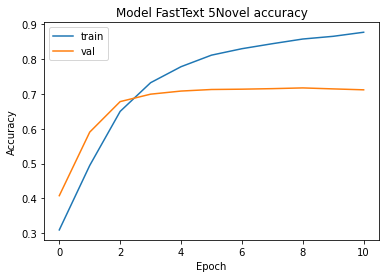

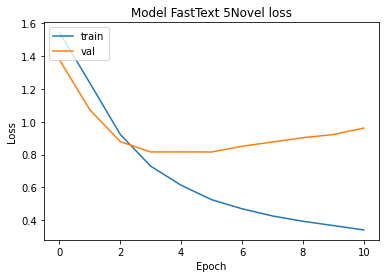

In [ ]:
plt.plot(hist_fast_org.history['accuracy'])
plt.plot(hist_fast_org.history['val_accuracy'])
plt.title('Model FastText 5Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_org.history['loss'])
plt.plot(hist_fast_org.history['val_loss'])
plt.title('Model FastText 5Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred_fast_org = model_fast_org.predict(test_padded)
sample_submission[['0','1','2','3','4']] = pred_fast_org
sample_submission

,index,0,1,2,3,4
0,0,2.643076e-07,7.080717e-05,9.999133e-01,1.496781e-05,6.301197e-07
1,1,1.227452e-02,2.062798e-02,3.006760e-02,9.297233e-01,7.306619e-03
2,2,9.999236e-01,6.786979e-05,1.335506e-08,3.499940e-09,8.546052e-06
3,3,2.404715e-02,1.700606e-04,6.973817e-01,2.746597e-01,3.741386e-03
4,4,9.015325e-01,4.297892e-03,4.253765e-03,8.841988e-02,1.495929e-03
...,...,...,...,...,...,...
19612,19612,3.238923e-06,9.999968e-01,9.006374e-10,2.368202e-09,2.330956e-10
19613,19613,2.544599e-06,1.839237e-07,2.153258e-08,1.309888e-13,9.999973e-01
19614,19614,3.090942e-05,9.999691e-01,2.233682e-08,5.403283e-09,4.092177e-10
19615,19615,6.126346e-09,1.000000e+00,6.187150e-13,6.610205e-15,2.819630e-15


In [ ]:
model_fast_org.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_fast_org.h5')


#### 4.2.1.2. FaseText 임베딩을 활용, 작가 8명 데이터셋

In [ ]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size_new, 100,weights = [FT_embedding_matrix_new], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [ ]:
conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

In [ ]:
# 3, 4, 5 - gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(8, name='logits')(dropout_hidden)
predictions = Dense(8, activation=tf.nn.softmax)(logits)

In [ ]:
model_fast_new = Model(inputs=input_layer,outputs=predictions)
model_fast_new.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_fast_new = model_fast_new.fit(train_padded_new,y_train_new, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
2081/2081 - 130s - loss: 1.9868 - accuracy: 0.2168 - val_loss: 1.6920 - val_accuracy: 0.3522
Epoch 2/30
2081/2081 - 129s - loss: 1.5603 - accuracy: 0.4053 - val_loss: 1.2979 - val_accuracy: 0.5135
Epoch 3/30
2081/2081 - 129s - loss: 1.2362 - accuracy: 0.5330 - val_loss: 1.1415 - val_accuracy: 0.5676
Epoch 4/30
2081/2081 - 129s - loss: 1.0423 - accuracy: 0.6057 - val_loss: 1.0664 - val_accuracy: 0.5928
Epoch 5/30
2081/2081 - 127s - loss: 0.9253 - accuracy: 0.6501 - val_loss: 1.0296 - val_accuracy: 0.6191
Epoch 6/30
2081/2081 - 127s - loss: 0.8364 - accuracy: 0.6800 - val_loss: 1.0280 - val_accuracy: 0.6248
Epoch 7/30
2081/2081 - 126s - loss: 0.7706 - accuracy: 0.7049 - val_loss: 0.9979 - val_accuracy: 0.6372
Epoch 8/30
2081/2081 - 126s - loss: 0.7264 - accuracy: 0.7181 - val_loss: 1.0382 - val_accuracy: 0.6182
Epoch 9/30
2081/2081 - 126s - loss: 0.6840 - accuracy: 0.7336 - val_loss: 1.0904 - val_accuracy: 0.6147
Epoch 10/30
2081/2081 - 126s - loss: 0.6530 - accuracy: 0.7425 -

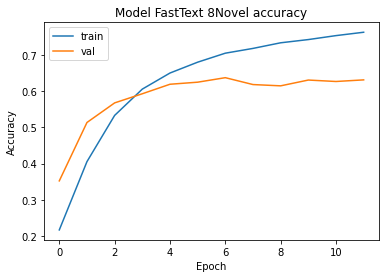

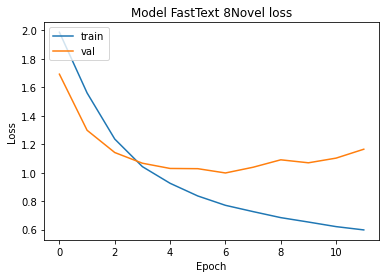

In [ ]:
plt.plot(hist_fast_new.history['accuracy'])
plt.plot(hist_fast_new.history['val_accuracy'])
plt.title('Model FastText 8Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_new.history['loss'])
plt.plot(hist_fast_new.history['val_loss'])
plt.title('Model FastText 8Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred_fast_new = model_fast_new.predict(test_padded_new)
sample_submission_new[['0','1','2','3','4','5','6','7']] = pred_fast_new
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,1.660067e-09,2.153196e-01,3.452292e-07,3.982781e-08,4.391035e-10,7.846782e-01,1.701444e-06,4.018415e-08
1,1,1.159880e-05,6.064726e-01,5.901470e-02,7.813841e-03,6.348841e-05,3.114192e-01,1.515305e-02,5.174567e-05
2,2,2.688417e-07,5.133784e-02,1.070626e-07,1.749263e-07,3.748618e-09,9.486498e-01,5.208918e-06,6.566359e-06
3,3,1.223216e-06,6.182856e-02,1.352993e-06,8.501377e-07,5.710002e-08,9.380985e-01,4.326327e-05,2.620064e-05
4,4,1.683798e-02,2.597826e-05,3.343221e-06,5.737178e-07,5.740763e-05,1.422555e-03,7.708211e-03,9.739439e-01
...,...,...,...,...,...,...,...,...,...
27313,27313,3.173018e-08,9.999992e-01,1.111385e-08,8.630598e-07,6.164220e-10,4.883155e-08,2.082737e-17,2.424035e-13
27314,27314,3.004895e-07,1.114529e-14,1.203667e-05,5.643258e-12,9.936978e-01,2.245320e-15,6.281432e-03,8.478477e-06
27315,27315,5.644668e-11,9.999964e-01,2.571731e-10,4.593483e-09,1.223635e-12,3.614564e-06,7.067808e-17,1.416254e-14
27316,27316,4.883537e-04,9.993437e-01,1.764535e-05,1.401769e-04,9.592385e-06,5.206282e-07,4.187831e-13,1.387022e-08


In [ ]:
model_fast_new.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_fast_new.h5')

#### 4.2.1.3. Glove 임베딩을 활용, 작가 5명 데이터셋


In [ ]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 50,weights = [g_embedding_matrix], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [ ]:
conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

In [ ]:
# 3, 4, 5 - gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

In [ ]:
model_glove_org = Model(inputs=input_layer,outputs=predictions)
model_glove_org.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_glove_org = model_glove_org.fit(train_padded,y_train, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 36s - loss: 1.5201 - accuracy: 0.3268 - val_loss: 1.3280 - val_accuracy: 0.4455
Epoch 2/30
1372/1372 - 34s - loss: 1.3222 - accuracy: 0.4530 - val_loss: 1.1072 - val_accuracy: 0.5714
Epoch 3/30
1372/1372 - 34s - loss: 1.1739 - accuracy: 0.5309 - val_loss: 1.0081 - val_accuracy: 0.6060
Epoch 4/30
1372/1372 - 34s - loss: 1.0649 - accuracy: 0.5857 - val_loss: 0.9105 - val_accuracy: 0.6529
Epoch 5/30
1372/1372 - 34s - loss: 0.9795 - accuracy: 0.6244 - val_loss: 0.8596 - val_accuracy: 0.6771
Epoch 6/30
1372/1372 - 35s - loss: 0.9085 - accuracy: 0.6548 - val_loss: 0.8369 - val_accuracy: 0.6880
Epoch 7/30
1372/1372 - 34s - loss: 0.8529 - accuracy: 0.6817 - val_loss: 0.8005 - val_accuracy: 0.7034
Epoch 8/30
1372/1372 - 34s - loss: 0.8040 - accuracy: 0.6995 - val_loss: 0.7654 - val_accuracy: 0.7150
Epoch 9/30
1372/1372 - 35s - loss: 0.7518 - accuracy: 0.7224 - val_loss: 0.7582 - val_accuracy: 0.7223
Epoch 10/30
1372/1372 - 37s - loss: 0.7165 - accuracy: 0.7358 - val_loss:

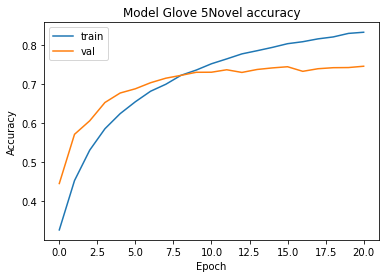

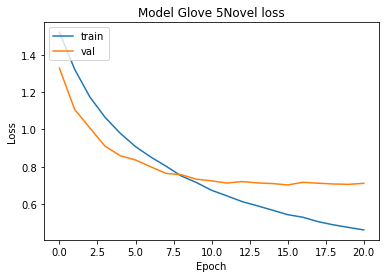

In [ ]:
plt.plot(hist_glove_org.history['accuracy'])
plt.plot(hist_glove_org.history['val_accuracy'])
plt.title('Model Glove 5Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_org.history['loss'])
plt.plot(hist_glove_org.history['val_loss'])
plt.title('Model Glove 5Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred_glove_org = model_glove_org.predict(test_padded)
sample_submission[['0','1','2','3','4']] = pred_glove_org
sample_submission

,index,0,1,2,3,4
0,0,0.000247,0.105264,8.913291e-01,2.866752e-03,2.935052e-04
1,1,0.273320,0.385903,5.065823e-02,2.110658e-01,7.905284e-02
2,2,0.999999,0.000001,9.459505e-10,7.091916e-09,1.726441e-07
3,3,0.000767,0.001732,9.839429e-01,1.335452e-02,2.041917e-04
4,4,0.668627,0.052500,3.184583e-02,2.025210e-01,4.450636e-02
...,...,...,...,...,...,...
19612,19612,0.000396,0.999587,9.411846e-08,1.608309e-05,8.553646e-08
19613,19613,0.001658,0.000147,1.346627e-03,2.087621e-05,9.968281e-01
19614,19614,0.000001,0.999999,4.078982e-09,2.547574e-07,8.513489e-11
19615,19615,0.000046,0.999946,6.936438e-07,7.260260e-06,3.336152e-08


In [ ]:
model_glove_org.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_glove_org.h5')

#### 4.2.1.4. Glove 임베딩을 활용, 작가 8명 데이터셋

In [ ]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size_new+1, 50,weights = [g_embedding_matrix_new], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [ ]:
conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

In [ ]:
# 3, 4, 5 - gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(8, name='logits')(dropout_hidden)
predictions = Dense(8, activation=tf.nn.softmax)(logits)

In [ ]:
model_glove_new = Model(inputs=input_layer,outputs=predictions)
model_glove_new.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_glove_new = model_glove_new.fit(train_padded_new,y_train_new, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
2081/2081 - 65s - loss: 1.9410 - accuracy: 0.2220 - val_loss: 1.8150 - val_accuracy: 0.2895
Epoch 2/30
2081/2081 - 62s - loss: 1.8120 - accuracy: 0.2856 - val_loss: 1.6627 - val_accuracy: 0.3619
Epoch 3/30
2081/2081 - 61s - loss: 1.6822 - accuracy: 0.3413 - val_loss: 1.5080 - val_accuracy: 0.4374
Epoch 4/30
2081/2081 - 61s - loss: 1.5574 - accuracy: 0.3975 - val_loss: 1.3661 - val_accuracy: 0.4956
Epoch 5/30
2081/2081 - 61s - loss: 1.4567 - accuracy: 0.4421 - val_loss: 1.2874 - val_accuracy: 0.5178
Epoch 6/30
2081/2081 - 62s - loss: 1.3894 - accuracy: 0.4651 - val_loss: 1.2401 - val_accuracy: 0.5258
Epoch 7/30
2081/2081 - 61s - loss: 1.3363 - accuracy: 0.4882 - val_loss: 1.1807 - val_accuracy: 0.5573
Epoch 8/30
2081/2081 - 62s - loss: 1.2844 - accuracy: 0.5073 - val_loss: 1.1597 - val_accuracy: 0.5622
Epoch 9/30
2081/2081 - 63s - loss: 1.2404 - accuracy: 0.5211 - val_loss: 1.1451 - val_accuracy: 0.5667
Epoch 10/30
2081/2081 - 63s - loss: 1.1893 - accuracy: 0.5421 - val_loss:

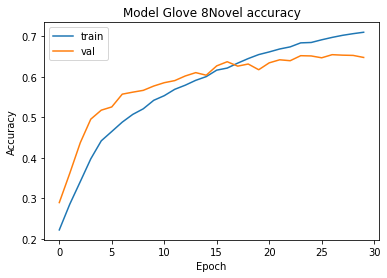

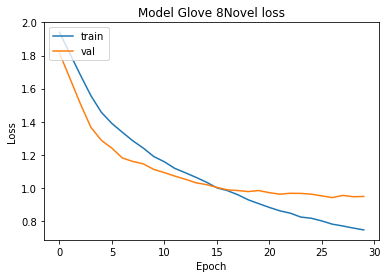

In [ ]:
plt.plot(hist_glove_new.history['accuracy'])
plt.plot(hist_glove_new.history['val_accuracy'])
plt.title('Model Glove 8Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_new.history['loss'])
plt.plot(hist_glove_new.history['val_loss'])
plt.title('Model Glove 8Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred_glove_new = model_glove_new.predict(test_padded_new)
sample_submission_new[['0','1','2','3','4','5','6','7']] = pred_glove_new
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,0.000103,6.374757e-01,4.259563e-05,1.803017e-04,8.120294e-07,3.621443e-01,1.445226e-06,5.236645e-05
1,1,0.000048,1.361949e-01,1.126968e-06,1.261667e-05,4.130935e-08,8.634503e-01,7.221441e-06,2.859293e-04
2,2,0.000272,9.076676e-02,1.641013e-06,1.282083e-05,1.414887e-07,9.058434e-01,4.251874e-05,3.060344e-03
3,3,0.000030,9.032983e-02,2.273663e-07,2.602938e-06,9.629172e-09,9.092719e-01,5.860762e-06,3.591914e-04
4,4,0.010061,5.692779e-02,1.229339e-04,3.155888e-04,3.638938e-05,7.609578e-01,8.291190e-03,1.632868e-01
...,...,...,...,...,...,...,...,...,...
27313,27313,0.000007,9.999886e-01,7.920163e-08,3.729562e-06,1.133104e-09,3.040618e-07,3.051733e-18,2.866301e-11
27314,27314,0.002142,1.629217e-08,6.705129e-04,3.813934e-07,8.179168e-01,1.358860e-08,1.756284e-01,3.642051e-03
27315,27315,0.000011,9.999819e-01,3.027334e-07,6.615356e-06,4.304823e-09,6.486404e-07,3.794256e-17,7.783550e-11
27316,27316,0.000242,9.997060e-01,5.546931e-06,4.048135e-05,2.754918e-07,5.243317e-06,1.104074e-14,9.279016e-09


In [ ]:
model_glove_new.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_glove_new.h5')

### 4.2.2. Long-CNN
layer 길게 늘려보기 커널 사이즈 7 - 6 - 5 - 4 - 3 으로 구성

In [ ]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

train_sequences_new = tokenizer.texts_to_sequences(X_train_new)
train_padded_new = pad_sequences(train_sequences_new, padding=padding_type, maxlen=max_length)

test_sequences_new = tokenizer.texts_to_sequences(X_test_new)
test_padded_new = pad_sequences(test_sequences_new, padding=padding_type, maxlen=max_length)

In [ ]:
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dropout,Dense, Conv1D, GlobalMaxPool1D, concatenate, MaxPool1D
import time
import matplotlib.pyplot as plt

In [ ]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size
VOCAB_SIZE_new = vocab_size_new

#### 4.2.2.1. FaseText 임베딩을 활용, 작가 5명 데이터셋

In [ ]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 100,weights = [FT_embedding_matrix], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [ ]:
conv1 = Conv1D(filters=128, kernel_size=7, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = MaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=6, padding='valid', activation=tf.nn.relu)(pool1)
pool2 = MaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(pool2)
pool3 = MaxPool1D()(conv3)
conv4 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(pool3)
pool4 = MaxPool1D()(conv4)
conv5 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(pool4)
pool5 = GlobalMaxPool1D()(conv5)

In [ ]:
hidden = Dense(128, activation=tf.nn.relu)(pool5)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

In [ ]:
model_fast_org_long = Model(inputs=input_layer,outputs=predictions)
model_fast_org_long.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_fast_org_long = model_fast_org_long.fit(train_padded,y_train,verbose=2, epochs=EPOCH,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 67s - loss: 1.5050 - accuracy: 0.3310 - val_loss: 1.3827 - val_accuracy: 0.3982
Epoch 2/30
1372/1372 - 63s - loss: 1.2246 - accuracy: 0.4786 - val_loss: 1.0830 - val_accuracy: 0.5606
Epoch 3/30
1372/1372 - 63s - loss: 0.9704 - accuracy: 0.6103 - val_loss: 0.9746 - val_accuracy: 0.6175
Epoch 4/30
1372/1372 - 62s - loss: 0.8013 - accuracy: 0.6933 - val_loss: 0.9007 - val_accuracy: 0.6589
Epoch 5/30
1372/1372 - 62s - loss: 0.6833 - accuracy: 0.7441 - val_loss: 0.8794 - val_accuracy: 0.6758
Epoch 6/30
1372/1372 - 62s - loss: 0.6035 - accuracy: 0.7780 - val_loss: 0.8955 - val_accuracy: 0.6803
Epoch 7/30
1372/1372 - 62s - loss: 0.5431 - accuracy: 0.7996 - val_loss: 0.9553 - val_accuracy: 0.6829
Epoch 8/30
1372/1372 - 62s - loss: 0.5024 - accuracy: 0.8164 - val_loss: 0.9141 - val_accuracy: 0.6923
Epoch 9/30
1372/1372 - 62s - loss: 0.4641 - accuracy: 0.8295 - val_loss: 1.0001 - val_accuracy: 0.6931
Epoch 10/30
1372/1372 - 62s - loss: 0.4420 - accuracy: 0.8413 - val_loss:

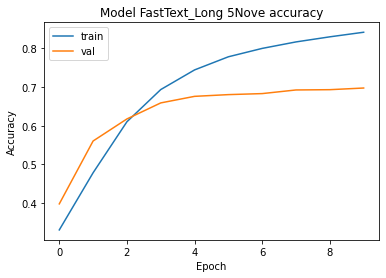

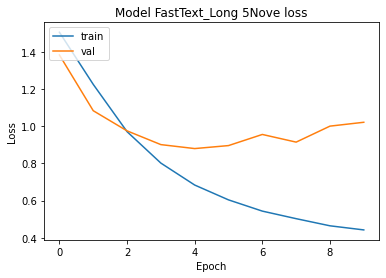

In [ ]:
plt.plot(hist_fast_org_long.history['accuracy'])
plt.plot(hist_fast_org_long.history['val_accuracy'])
plt.title('Model FastText_Long 5Nove accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_org_long.history['loss'])
plt.plot(hist_fast_org_long.history['val_loss'])
plt.title('Model FastText_Long 5Nove loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred_fast_org_long = model_fast_org_long.predict(test_padded)
sample_submission[['0','1','2','3','4']] = pred_fast_org_long
sample_submission

,index,0,1,2,3,4
0,0,1.483888e-05,6.293955e-05,9.983461e-01,4.817483e-04,1.094275e-03
1,1,2.772425e-02,3.086009e-03,3.212691e-01,4.708197e-01,1.771009e-01
2,2,9.999985e-01,1.517021e-06,1.303726e-16,2.551200e-15,4.162578e-11
3,3,5.123718e-09,4.520864e-09,9.761595e-01,2.382482e-02,1.576239e-05
4,4,3.427707e-01,1.764468e-01,1.805400e-01,1.253234e-01,1.749190e-01
...,...,...,...,...,...,...
19612,19612,1.655271e-12,1.000000e+00,4.611420e-19,8.024340e-19,6.016246e-24
19613,19613,7.905643e-08,1.390475e-14,1.146007e-07,2.934090e-14,9.999998e-01
19614,19614,3.901334e-07,9.999996e-01,1.424079e-10,8.454951e-11,2.513781e-13
19615,19615,2.656801e-09,1.000000e+00,1.764071e-13,4.689175e-13,3.429090e-17


In [ ]:
model_fast_org_long.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_fast_org_long.h5')


#### 4.2.2.2. FaseText 임베딩을 활용, 작가 8명 데이터셋


In [ ]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size_new, 100,weights = [FT_embedding_matrix_new], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [ ]:
conv1 = Conv1D(filters=128, kernel_size=7, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = MaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=6, padding='valid', activation=tf.nn.relu)(pool1)
pool2 = MaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(pool2)
pool3 = MaxPool1D()(conv3)
conv4 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(pool3)
pool4 = MaxPool1D()(conv4)
conv5 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(pool4)
pool5 = GlobalMaxPool1D()(conv5)

In [ ]:
hidden = Dense(128, activation=tf.nn.relu)(pool5)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(8, name='logits')(dropout_hidden)
predictions = Dense(8, activation=tf.nn.softmax)(logits)

In [ ]:
model_fast_new_long = Model(inputs=input_layer,outputs=predictions)
model_fast_new_long.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_fast_new_long = model_fast_new_long.fit(train_padded_new,y_train_new, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
2081/2081 - 130s - loss: 1.8575 - accuracy: 0.2652 - val_loss: 1.5121 - val_accuracy: 0.4152
Epoch 2/30
2081/2081 - 129s - loss: 1.4377 - accuracy: 0.4395 - val_loss: 1.3188 - val_accuracy: 0.4816
Epoch 3/30
2081/2081 - 130s - loss: 1.2671 - accuracy: 0.5009 - val_loss: 1.2323 - val_accuracy: 0.5168
Epoch 4/30
2081/2081 - 130s - loss: 1.1616 - accuracy: 0.5404 - val_loss: 1.1987 - val_accuracy: 0.5395
Epoch 5/30
2081/2081 - 130s - loss: 1.0735 - accuracy: 0.5755 - val_loss: 1.1493 - val_accuracy: 0.5598
Epoch 6/30
2081/2081 - 130s - loss: 1.0017 - accuracy: 0.6044 - val_loss: 1.1376 - val_accuracy: 0.5598
Epoch 7/30
2081/2081 - 130s - loss: 0.9350 - accuracy: 0.6333 - val_loss: 1.1234 - val_accuracy: 0.5868
Epoch 8/30
2081/2081 - 130s - loss: 0.8774 - accuracy: 0.6548 - val_loss: 1.1860 - val_accuracy: 0.5902
Epoch 9/30
2081/2081 - 130s - loss: 0.8310 - accuracy: 0.6710 - val_loss: 1.1115 - val_accuracy: 0.6000
Epoch 10/30
2081/2081 - 130s - loss: 0.7925 - accuracy: 0.6895 -

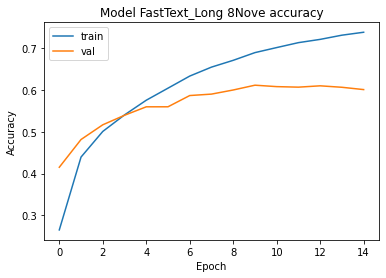

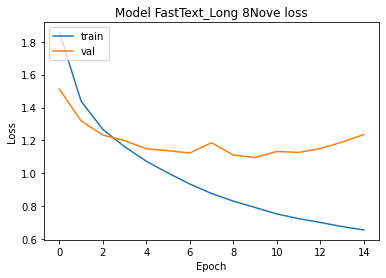

In [ ]:
plt.plot(hist_fast_new_long.history['accuracy'])
plt.plot(hist_fast_new_long.history['val_accuracy'])
plt.title('Model FastText_Long 8Nove accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_new_long.history['loss'])
plt.plot(hist_fast_new_long.history['val_loss'])
plt.title('Model FastText_Long 8Nove loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred_fast_new_long = model_fast_new_long.predict(test_padded_new)
sample_submission_new[['0','1','2','3','4','5','6','7']] = pred_fast_new_long
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,4.633769e-10,0.010984,3.628380e-16,9.517124e-15,1.567928e-16,9.890162e-01,2.275837e-16,5.483754e-09
1,1,3.910306e-06,0.568892,5.973572e-05,1.820542e-06,9.188309e-07,4.310390e-01,3.247695e-08,2.235172e-06
2,2,1.463654e-05,0.098668,2.008730e-08,7.299592e-08,6.075129e-09,9.012708e-01,9.761578e-09,4.665081e-05
3,3,9.555998e-06,0.043920,2.939748e-11,9.332154e-11,4.151676e-11,9.560161e-01,1.673268e-11,5.387333e-05
4,4,5.280179e-02,0.034453,6.851044e-06,1.835565e-05,2.184708e-05,4.815996e-01,5.123008e-05,4.310475e-01
...,...,...,...,...,...,...,...,...,...
27313,27313,3.255262e-12,1.000000,6.051827e-18,1.389399e-18,1.590112e-18,8.318602e-11,0.000000e+00,5.432698e-23
27314,27314,4.386721e-01,0.000135,5.905858e-03,1.129433e-04,3.613884e-01,2.277038e-05,6.182184e-03,1.875803e-01
27315,27315,3.985209e-07,0.999999,3.797560e-09,6.683575e-09,8.396390e-10,3.794110e-07,4.639287e-22,6.549787e-14
27316,27316,1.049728e-04,0.999696,9.879309e-07,1.789178e-06,2.968353e-07,1.961650e-04,1.128263e-14,1.092049e-08


In [ ]:
model_fast_new_long.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_fast_new_long.h5')

#### 4.2.2.3. Glove 임베딩을 활용, 작가 5명 데이터셋


In [ ]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 50,weights = [g_embedding_matrix], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [ ]:
conv1 = Conv1D(filters=128, kernel_size=7, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = MaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=6, padding='valid', activation=tf.nn.relu)(pool1)
pool2 = MaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(pool2)
pool3 = MaxPool1D()(conv3)
conv4 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(pool3)
pool4 = MaxPool1D()(conv4)
conv5 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(pool4)
pool5 = GlobalMaxPool1D()(conv5)

In [ ]:
hidden = Dense(128, activation=tf.nn.relu)(pool5)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

In [ ]:
model_glove_org_long = Model(inputs=input_layer,outputs=predictions)
model_glove_org_long.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_glove_org_long = model_glove_org_long.fit(train_padded,y_train, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 36s - loss: 1.4675 - accuracy: 0.3421 - val_loss: 1.3408 - val_accuracy: 0.4339
Epoch 2/30
1372/1372 - 35s - loss: 1.2529 - accuracy: 0.4802 - val_loss: 1.1276 - val_accuracy: 0.5415
Epoch 3/30
1372/1372 - 34s - loss: 1.0917 - accuracy: 0.5584 - val_loss: 0.9925 - val_accuracy: 0.6068
Epoch 4/30
1372/1372 - 34s - loss: 0.9930 - accuracy: 0.6055 - val_loss: 0.9511 - val_accuracy: 0.6297
Epoch 5/30
1372/1372 - 35s - loss: 0.9170 - accuracy: 0.6436 - val_loss: 0.8961 - val_accuracy: 0.6550
Epoch 6/30
1372/1372 - 34s - loss: 0.8445 - accuracy: 0.6771 - val_loss: 0.8433 - val_accuracy: 0.6826
Epoch 7/30
1372/1372 - 34s - loss: 0.7978 - accuracy: 0.6988 - val_loss: 0.8565 - val_accuracy: 0.6784
Epoch 8/30
1372/1372 - 34s - loss: 0.7525 - accuracy: 0.7186 - val_loss: 0.8464 - val_accuracy: 0.6813
Epoch 9/30
1372/1372 - 34s - loss: 0.7119 - accuracy: 0.7351 - val_loss: 0.7949 - val_accuracy: 0.7065
Epoch 10/30
1372/1372 - 34s - loss: 0.6798 - accuracy: 0.7474 - val_loss:

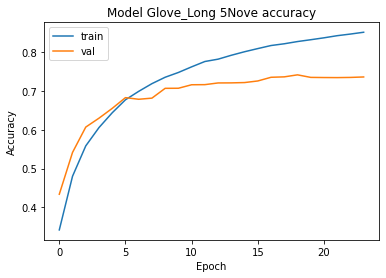

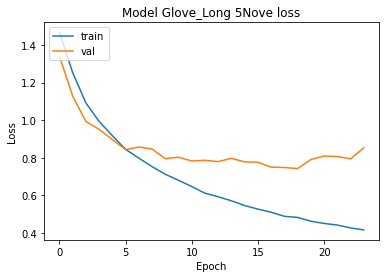

In [ ]:
plt.plot(hist_glove_org_long.history['accuracy'])
plt.plot(hist_glove_org_long.history['val_accuracy'])
plt.title('Model Glove_Long 5Nove accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_org_long.history['loss'])
plt.plot(hist_glove_org_long.history['val_loss'])
plt.title('Model Glove_Long 5Nove loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred_glove_org_long = model_glove_org_long.predict(test_padded)
sample_submission[['0','1','2','3','4']] = pred_glove_org_long
sample_submission

,index,0,1,2,3,4
0,0,1.504621e-03,7.954248e-01,1.959944e-01,6.905654e-03,1.704722e-04
1,1,4.898875e-01,2.280823e-01,1.090052e-01,4.752301e-02,1.255019e-01
2,2,1.000000e+00,4.528381e-08,2.499825e-17,3.806593e-12,6.808089e-12
3,3,4.827359e-08,1.564394e-05,9.996443e-01,2.428824e-06,3.376153e-04
4,4,9.862936e-01,6.449004e-03,1.454330e-04,4.129281e-03,2.982802e-03
...,...,...,...,...,...,...
19612,19612,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
19613,19613,3.351962e-05,4.204875e-09,3.095794e-05,5.141162e-09,9.999355e-01
19614,19614,2.989242e-12,1.000000e+00,1.960836e-14,3.441768e-14,1.813983e-20
19615,19615,3.296693e-17,1.000000e+00,2.235299e-22,2.947778e-21,1.190369e-30


In [ ]:
model_glove_org_long.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_glove_org_long.h5')

#### 4.2.2.4. Glove 임베딩을 활용, 작가 8명 데이터셋


In [ ]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size_new+1, 50,weights = [g_embedding_matrix_new], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [ ]:
conv1 = Conv1D(filters=128, kernel_size=7, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = MaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=6, padding='valid', activation=tf.nn.relu)(pool1)
pool2 = MaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(pool2)
pool3 = MaxPool1D()(conv3)
conv4 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(pool3)
pool4 = MaxPool1D()(conv4)
conv5 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(pool4)
pool5 = GlobalMaxPool1D()(conv5)

In [ ]:
hidden = Dense(128, activation=tf.nn.relu)(pool5)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(8, name='logits')(dropout_hidden)
predictions = Dense(8, activation=tf.nn.softmax)(logits)

In [ ]:
model_glove_new_long = Model(inputs=input_layer,outputs=predictions)
model_glove_new_long.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_glove_new_long = model_glove_new_long.fit(train_padded_new,y_train_new, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
2081/2081 - 63s - loss: 1.9009 - accuracy: 0.2321 - val_loss: 1.7951 - val_accuracy: 0.2770
Epoch 2/30
2081/2081 - 62s - loss: 1.7072 - accuracy: 0.3289 - val_loss: 1.5816 - val_accuracy: 0.3805
Epoch 3/30
2081/2081 - 62s - loss: 1.5510 - accuracy: 0.3992 - val_loss: 1.4402 - val_accuracy: 0.4438
Epoch 4/30
2081/2081 - 62s - loss: 1.4202 - accuracy: 0.4542 - val_loss: 1.3583 - val_accuracy: 0.4785
Epoch 5/30
2081/2081 - 63s - loss: 1.3168 - accuracy: 0.4945 - val_loss: 1.2527 - val_accuracy: 0.5129
Epoch 6/30
2081/2081 - 62s - loss: 1.2381 - accuracy: 0.5221 - val_loss: 1.1780 - val_accuracy: 0.5478
Epoch 7/30
2081/2081 - 62s - loss: 1.1746 - accuracy: 0.5474 - val_loss: 1.2274 - val_accuracy: 0.5310
Epoch 8/30
2081/2081 - 62s - loss: 1.1195 - accuracy: 0.5634 - val_loss: 1.1072 - val_accuracy: 0.5705
Epoch 9/30
2081/2081 - 62s - loss: 1.0759 - accuracy: 0.5804 - val_loss: 1.0834 - val_accuracy: 0.5816
Epoch 10/30
2081/2081 - 63s - loss: 1.0343 - accuracy: 0.5976 - val_loss:

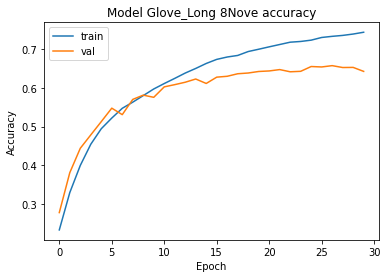

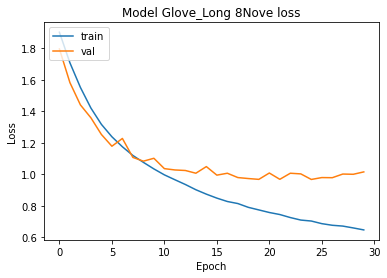

In [ ]:
plt.plot(hist_glove_new_long.history['accuracy'])
plt.plot(hist_glove_new_long.history['val_accuracy'])
plt.title('Model Glove_Long 8Nove accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_new_long.history['loss'])
plt.plot(hist_glove_new_long.history['val_loss'])
plt.title('Model Glove_Long 8Nove loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred_glove_new_long = model_glove_new_long.predict(test_padded_new)
sample_submission_new[['0','1','2','3','4','5','6','7']] = pred_glove_new_long
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,9.152864e-12,0.005084,4.234708e-13,6.304905e-14,1.368433e-16,9.949163e-01,1.276993e-12,1.340284e-10
1,1,5.813179e-07,0.023734,7.489608e-06,7.905161e-09,1.264934e-08,9.762393e-01,7.200347e-07,1.784321e-05
2,2,4.307517e-04,0.020669,1.216004e-05,2.528166e-06,3.840430e-07,9.700342e-01,2.567995e-05,8.825606e-03
3,3,4.250509e-08,0.003994,5.623144e-11,6.854806e-11,5.077022e-13,9.960048e-01,3.887544e-10,1.224811e-06
4,4,1.198655e-05,0.020273,3.784083e-07,1.121552e-07,6.220593e-09,9.795558e-01,1.986496e-06,1.572269e-04
...,...,...,...,...,...,...,...,...,...
27313,27313,4.348725e-38,1.000000,1.985099e-30,4.451045e-27,0.000000e+00,2.335529e-18,0.000000e+00,0.000000e+00
27314,27314,2.020397e-01,0.000248,4.744900e-03,3.505134e-05,6.804056e-01,4.482737e-05,5.927656e-05,1.124223e-01
27315,27315,4.343117e-07,0.999999,2.736805e-08,1.042393e-07,2.773510e-09,2.798925e-11,1.360062e-20,1.430062e-17
27316,27316,1.373719e-08,1.000000,8.621227e-09,2.532093e-08,1.310138e-10,1.426665e-10,2.382109e-20,1.785358e-18


In [ ]:
model_glove_new_long.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_glove_new_long.h5')

### 4.2.3. Wide-CNN
커널은 사이즈가 4인 커널 2개, 3인 커널 2개, 2인 커널 2개를 사용했다.

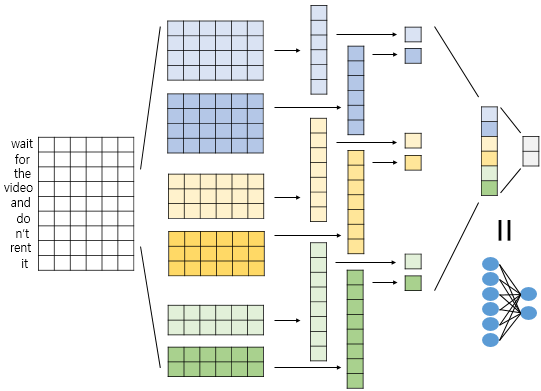

In [ ]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

train_sequences_new = tokenizer.texts_to_sequences(X_train_new)
train_padded_new = pad_sequences(train_sequences_new, padding=padding_type, maxlen=max_length)

test_sequences_new = tokenizer.texts_to_sequences(X_test_new)
test_padded_new = pad_sequences(test_sequences_new, padding=padding_type, maxlen=max_length)

In [ ]:
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dropout,Dense, Conv1D, GlobalMaxPool1D, concatenate, MaxPool1D
import time
import matplotlib.pyplot as plt

In [ ]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size
VOCAB_SIZE_new = vocab_size_new

#### 4.2.3.1. FaseText 임베딩을 활용, 작가 5명 데이터셋

In [ ]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 100,weights = [FT_embedding_matrix], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [ ]:
conv1_1 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1_1 = GlobalMaxPool1D()(conv1_1)
conv1_2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1_2 = GlobalMaxPool1D()(conv1_2)
conv2_1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2_1 = GlobalMaxPool1D()(conv2_1)
conv2_2 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2_2 = GlobalMaxPool1D()(conv2_2)
conv3_1 = Conv1D(filters=128, kernel_size=2, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3_1 = GlobalMaxPool1D()(conv3_1)
conv3_2 = Conv1D(filters=128, kernel_size=2, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3_2 = GlobalMaxPool1D()(conv3_2)

In [ ]:
concat = concatenate([pool1_1,pool1_2 , pool2_1, pool2_2, pool3_1, pool3_2])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

In [ ]:
model_fast_org_wide = Model(inputs=input_layer,outputs=predictions)
model_fast_org_wide.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_fast_org_wide = model_fast_org_wide.fit(train_padded,y_train,verbose=2, epochs=EPOCH,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 70s - loss: 1.5768 - accuracy: 0.2740 - val_loss: 1.5693 - val_accuracy: 0.2681
Epoch 2/30
1372/1372 - 68s - loss: 1.5679 - accuracy: 0.2791 - val_loss: 1.5668 - val_accuracy: 0.2747
Epoch 3/30
1372/1372 - 69s - loss: 1.5591 - accuracy: 0.2849 - val_loss: 1.5449 - val_accuracy: 0.3572
Epoch 4/30
1372/1372 - 68s - loss: 1.3755 - accuracy: 0.4091 - val_loss: 1.2080 - val_accuracy: 0.4858
Epoch 5/30
1372/1372 - 68s - loss: 1.1422 - accuracy: 0.5163 - val_loss: 1.0954 - val_accuracy: 0.5509
Epoch 6/30
1372/1372 - 68s - loss: 0.9682 - accuracy: 0.6006 - val_loss: 0.9958 - val_accuracy: 0.6194
Epoch 7/30
1372/1372 - 68s - loss: 0.8180 - accuracy: 0.6846 - val_loss: 0.9208 - val_accuracy: 0.6637
Epoch 8/30
1372/1372 - 68s - loss: 0.7078 - accuracy: 0.7389 - val_loss: 0.9300 - val_accuracy: 0.6588
Epoch 9/30
1372/1372 - 68s - loss: 0.6333 - accuracy: 0.7697 - val_loss: 0.9290 - val_accuracy: 0.6708
Epoch 10/30
1372/1372 - 68s - loss: 0.5668 - accuracy: 0.7927 - val_loss:

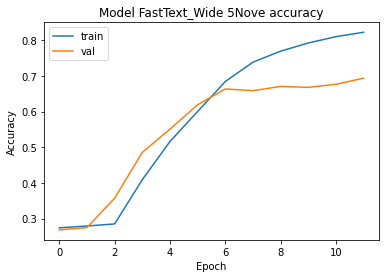

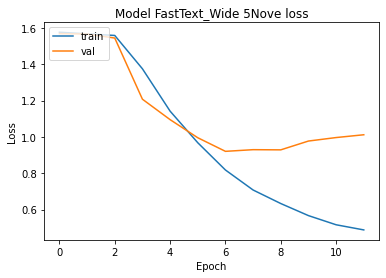

In [ ]:
plt.plot(hist_fast_org_wide.history['accuracy'])
plt.plot(hist_fast_org_wide.history['val_accuracy'])
plt.title('Model FastText_Wide 5Nove accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_org_wide.history['loss'])
plt.plot(hist_fast_org_wide.history['val_loss'])
plt.title('Model FastText_Wide 5Nove loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred_fast_org_wide = model_fast_org_wide.predict(test_padded)
sample_submission[['0','1','2','3','4']] = pred_fast_org_wide
sample_submission

,index,0,1,2,3,4
0,0,2.670747e-06,2.223150e-07,9.984823e-01,1.514559e-03,3.440777e-07
1,1,1.396762e-02,1.132298e-02,5.346874e-02,9.203603e-01,8.803526e-04
2,2,9.999945e-01,3.344102e-06,2.581245e-13,2.428963e-16,2.152002e-06
3,3,5.848231e-05,2.298227e-07,7.816702e-02,9.217685e-01,5.677840e-06
4,4,5.781224e-01,2.874525e-01,2.957534e-02,2.606623e-02,7.878348e-02
...,...,...,...,...,...,...
19612,19612,2.177409e-04,9.977134e-01,6.609369e-06,2.062134e-03,1.855701e-08
19613,19613,9.814097e-06,5.183563e-11,1.695540e-05,6.015406e-13,9.999732e-01
19614,19614,4.115734e-05,9.999105e-01,4.347955e-08,4.833213e-05,1.266608e-10
19615,19615,1.044909e-07,9.999802e-01,2.756700e-10,1.966872e-05,8.840837e-15


In [ ]:
model_fast_org_wide.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_fast_org_wide.h5')


#### 4.2.3.2. FaseText 임베딩을 활용, 작가 8명 데이터셋


In [ ]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size_new, 100,weights = [FT_embedding_matrix_new], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [ ]:
conv1_1 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1_1 = GlobalMaxPool1D()(conv1_1)
conv1_2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1_2 = GlobalMaxPool1D()(conv1_2)
conv2_1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2_1 = GlobalMaxPool1D()(conv2_1)
conv2_2 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2_2 = GlobalMaxPool1D()(conv2_2)
conv3_1 = Conv1D(filters=128, kernel_size=2, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3_1 = GlobalMaxPool1D()(conv3_1)
conv3_2 = Conv1D(filters=128, kernel_size=2, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3_2 = GlobalMaxPool1D()(conv3_2)

In [ ]:
concat = concatenate([pool1_1,pool1_2 , pool2_1, pool2_2, pool3_1, pool3_2])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(8, name='logits')(dropout_hidden)
predictions = Dense(8, activation=tf.nn.softmax)(logits)

In [ ]:
model_fast_new_wide = Model(inputs=input_layer,outputs=predictions)
model_fast_new_wide.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_fast_new_wide = model_fast_new_wide.fit(train_padded_new,y_train_new, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
2081/2081 - 131s - loss: 2.0350 - accuracy: 0.1849 - val_loss: 1.9742 - val_accuracy: 0.2463
Epoch 2/30
2081/2081 - 129s - loss: 1.9037 - accuracy: 0.2612 - val_loss: 1.6014 - val_accuracy: 0.3813
Epoch 3/30
2081/2081 - 129s - loss: 1.5738 - accuracy: 0.3897 - val_loss: 1.3951 - val_accuracy: 0.4551
Epoch 4/30
2081/2081 - 129s - loss: 1.3659 - accuracy: 0.4726 - val_loss: 1.2828 - val_accuracy: 0.4950
Epoch 5/30
2081/2081 - 129s - loss: 1.2097 - accuracy: 0.5323 - val_loss: 1.1744 - val_accuracy: 0.5470
Epoch 6/30
2081/2081 - 129s - loss: 1.0857 - accuracy: 0.5794 - val_loss: 1.1480 - val_accuracy: 0.5481
Epoch 7/30
2081/2081 - 129s - loss: 0.9744 - accuracy: 0.6228 - val_loss: 1.1414 - val_accuracy: 0.5571
Epoch 8/30
2081/2081 - 129s - loss: 0.8938 - accuracy: 0.6535 - val_loss: 1.0765 - val_accuracy: 0.5972
Epoch 9/30
2081/2081 - 129s - loss: 0.8364 - accuracy: 0.6752 - val_loss: 1.0897 - val_accuracy: 0.5910
Epoch 10/30
2081/2081 - 129s - loss: 0.7916 - accuracy: 0.6928 -

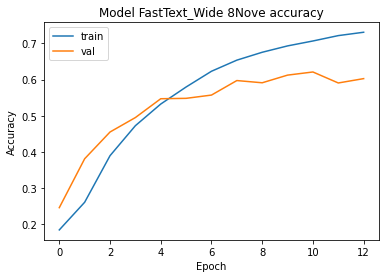

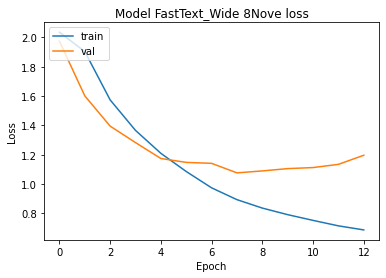

In [ ]:
plt.plot(hist_fast_new_wide.history['accuracy'])
plt.plot(hist_fast_new_wide.history['val_accuracy'])
plt.title('Model FastText_Wide 8Nove accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_new_wide.history['loss'])
plt.plot(hist_fast_new_wide.history['val_loss'])
plt.title('Model FastText_Wide 8Nove loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred_fast_new_wide = model_fast_new_wide.predict(test_padded_new)
sample_submission_new[['0','1','2','3','4','5','6','7']] = pred_fast_new_wide
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,2.421407e-10,1.774742e-03,3.515092e-14,2.040225e-13,4.949230e-15,9.982243e-01,1.883674e-07,7.568285e-07
1,1,4.997990e-04,7.204313e-01,1.137136e-04,4.017718e-04,3.210833e-05,2.775736e-01,1.012108e-04,8.464790e-04
2,2,3.783545e-06,7.886993e-02,8.693059e-08,5.811464e-07,2.001867e-08,9.209743e-01,2.899693e-05,1.222867e-04
3,3,6.758197e-06,4.023818e-02,1.554582e-08,9.315421e-08,8.969902e-09,9.594766e-01,1.516922e-05,2.631960e-04
4,4,7.955160e-02,1.710955e-03,2.340851e-07,3.229059e-07,7.568905e-06,1.076489e-01,3.269935e-04,8.107533e-01
...,...,...,...,...,...,...,...,...,...
27313,27313,5.927758e-09,9.999990e-01,8.989287e-13,5.767878e-09,4.519442e-13,9.650788e-07,1.095950e-20,1.121884e-13
27314,27314,6.485359e-03,1.705198e-09,1.969211e-04,1.412994e-07,9.883251e-01,2.109648e-11,5.197469e-05,4.940541e-03
27315,27315,7.050815e-10,9.999852e-01,1.265409e-13,3.516233e-10,3.744131e-14,1.472544e-05,1.995673e-19,2.800826e-13
27316,27316,9.053002e-03,9.905820e-01,2.614665e-05,2.978520e-04,3.234366e-05,8.238721e-06,3.447241e-13,3.379680e-07


In [ ]:
model_fast_new_wide.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_fast_new_wide.h5')

#### 4.2.3.3. Glove 임베딩을 활용, 작가 5명 데이터셋

In [ ]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 50,weights = [g_embedding_matrix], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [ ]:
conv1_1 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1_1 = GlobalMaxPool1D()(conv1_1)
conv1_2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1_2 = GlobalMaxPool1D()(conv1_2)
conv2_1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2_1 = GlobalMaxPool1D()(conv2_1)
conv2_2 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2_2 = GlobalMaxPool1D()(conv2_2)
conv3_1 = Conv1D(filters=128, kernel_size=2, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3_1 = GlobalMaxPool1D()(conv3_1)
conv3_2 = Conv1D(filters=128, kernel_size=2, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3_2 = GlobalMaxPool1D()(conv3_2)

In [ ]:
concat = concatenate([pool1_1,pool1_2 , pool2_1, pool2_2, pool3_1, pool3_2])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

In [ ]:
model_glove_org_wide = Model(inputs=input_layer,outputs=predictions)
model_glove_org_wide.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_glove_org_wide = model_glove_org_wide.fit(train_padded,y_train, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 36s - loss: 1.5276 - accuracy: 0.3169 - val_loss: 1.3486 - val_accuracy: 0.4393
Epoch 2/30
1372/1372 - 35s - loss: 1.3563 - accuracy: 0.4302 - val_loss: 1.1981 - val_accuracy: 0.5282
Epoch 3/30
1372/1372 - 34s - loss: 1.2489 - accuracy: 0.4845 - val_loss: 1.1008 - val_accuracy: 0.5594
Epoch 4/30
1372/1372 - 34s - loss: 1.1729 - accuracy: 0.5297 - val_loss: 1.0064 - val_accuracy: 0.6164
Epoch 5/30
1372/1372 - 34s - loss: 1.1115 - accuracy: 0.5574 - val_loss: 0.9471 - val_accuracy: 0.6388
Epoch 6/30
1372/1372 - 35s - loss: 1.0569 - accuracy: 0.5877 - val_loss: 0.8984 - val_accuracy: 0.6679
Epoch 7/30
1372/1372 - 34s - loss: 1.0027 - accuracy: 0.6115 - val_loss: 0.8868 - val_accuracy: 0.6678
Epoch 8/30
1372/1372 - 34s - loss: 0.9484 - accuracy: 0.6332 - val_loss: 0.8443 - val_accuracy: 0.6783
Epoch 9/30
1372/1372 - 34s - loss: 0.9020 - accuracy: 0.6565 - val_loss: 0.8088 - val_accuracy: 0.7020
Epoch 10/30
1372/1372 - 35s - loss: 0.8663 - accuracy: 0.6722 - val_loss:

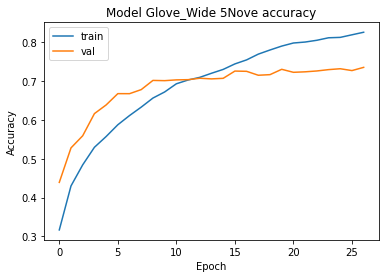

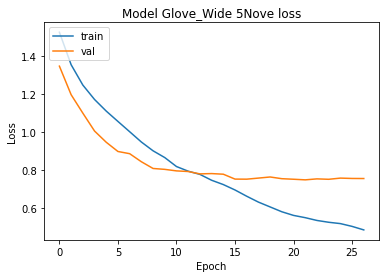

In [ ]:
plt.plot(hist_glove_org_wide.history['accuracy'])
plt.plot(hist_glove_org_wide.history['val_accuracy'])
plt.title('Model Glove_Wide 5Nove accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_org_wide.history['loss'])
plt.plot(hist_glove_org_wide.history['val_loss'])
plt.title('Model Glove_Wide 5Nove loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred_glove_org_wide = model_glove_org_wide.predict(test_padded)
sample_submission[['0','1','2','3','4']] = pred_glove_org_wide
sample_submission

,index,0,1,2,3,4
0,0,1.704678e-05,1.532790e-03,9.963019e-01,3.448855e-04,1.803338e-03
1,1,2.506628e-01,1.357672e-01,8.988760e-02,3.572778e-01,1.664045e-01
2,2,9.999975e-01,1.909478e-06,9.966928e-14,6.305808e-13,6.342267e-07
3,3,1.350293e-03,3.387095e-03,9.651414e-01,1.600135e-02,1.412002e-02
4,4,8.713756e-01,6.895933e-02,5.117011e-03,1.120823e-02,4.333976e-02
...,...,...,...,...,...,...
19612,19612,2.760934e-05,9.999484e-01,1.018922e-07,2.383867e-05,9.821703e-09
19613,19613,7.130595e-05,2.311376e-07,2.299235e-04,3.848361e-06,9.996947e-01
19614,19614,2.582285e-07,9.999993e-01,1.035109e-09,5.102004e-07,7.664352e-12
19615,19615,1.939461e-09,1.000000e+00,9.194550e-11,3.790711e-08,2.250563e-14


In [ ]:
model_glove_org_wide.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_glove_org_wide.h5')

#### 4.2.3.4. Glove 임베딩을 활용, 작가 8명 데이터셋


In [ ]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size_new+1, 50,weights = [g_embedding_matrix_new], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [ ]:
conv1_1 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1_1 = GlobalMaxPool1D()(conv1_1)
conv1_2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1_2 = GlobalMaxPool1D()(conv1_2)
conv2_1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2_1 = GlobalMaxPool1D()(conv2_1)
conv2_2 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2_2 = GlobalMaxPool1D()(conv2_2)
conv3_1 = Conv1D(filters=128, kernel_size=2, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3_1 = GlobalMaxPool1D()(conv3_1)
conv3_2 = Conv1D(filters=128, kernel_size=2, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3_2 = GlobalMaxPool1D()(conv3_2)

In [ ]:
concat = concatenate([pool1_1,pool1_2 , pool2_1, pool2_2, pool3_1, pool3_2])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(8, name='logits')(dropout_hidden)
predictions = Dense(8, activation=tf.nn.softmax)(logits)

In [ ]:
model_glove_new_wide_200 = Model(inputs=input_layer,outputs=predictions)
model_glove_new_wide_200.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_glove_new_wide_200 = model_glove_new_wide_200.fit(train_padded_new,y_train_new, epochs=200, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/200
2081/2081 - 68s - loss: 2.0029 - accuracy: 0.1881 - val_loss: 1.8793 - val_accuracy: 0.2508
Epoch 2/200
2081/2081 - 66s - loss: 1.9496 - accuracy: 0.2180 - val_loss: 1.8477 - val_accuracy: 0.2757
Epoch 3/200
2081/2081 - 65s - loss: 1.9263 - accuracy: 0.2299 - val_loss: 1.8222 - val_accuracy: 0.2862
Epoch 4/200
2081/2081 - 65s - loss: 1.9089 - accuracy: 0.2411 - val_loss: 1.7524 - val_accuracy: 0.3261
Epoch 5/200
2081/2081 - 66s - loss: 1.8927 - accuracy: 0.2441 - val_loss: 1.7421 - val_accuracy: 0.3277
Epoch 6/200
2081/2081 - 65s - loss: 1.8795 - accuracy: 0.2478 - val_loss: 1.7187 - val_accuracy: 0.3380
Epoch 7/200
2081/2081 - 65s - loss: 1.8675 - accuracy: 0.2482 - val_loss: 1.6886 - val_accuracy: 0.3496
Epoch 8/200
2081/2081 - 64s - loss: 1.8537 - accuracy: 0.2507 - val_loss: 1.6665 - val_accuracy: 0.3537
Epoch 9/200
2081/2081 - 64s - loss: 1.8490 - accuracy: 0.2508 - val_loss: 1.6283 - val_accuracy: 0.3565
Epoch 10/200
2081/2081 - 64s - loss: 1.8393 - accuracy: 0.2466 -

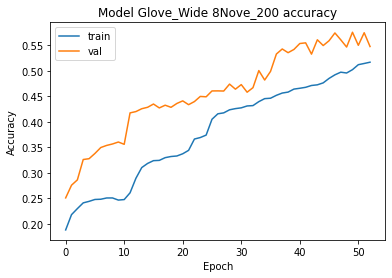

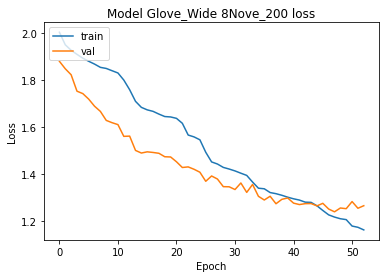

In [ ]:
plt.plot(hist_glove_new_wide_200.history['accuracy'])
plt.plot(hist_glove_new_wide_200.history['val_accuracy'])
plt.title('Model Glove_Wide 8Nove_200 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_new_wide_200.history['loss'])
plt.plot(hist_glove_new_wide_200.history['val_loss'])
plt.title('Model Glove_Wide 8Nove_200 loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred_glove_new_wide_200 = model_glove_new_wide_200.predict(test_padded_new)
sample_submission_new[['0','1','2','3','4','5','6','7']] = pred_glove_new_wide_200
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,2.161727e-01,1.267584e-01,0.045671,0.020911,0.015699,2.976650e-01,0.011537,2.655863e-01
1,1,2.161727e-01,1.267584e-01,0.045671,0.020911,0.015699,2.976650e-01,0.011537,2.655863e-01
2,2,2.161727e-01,1.267584e-01,0.045671,0.020911,0.015699,2.976650e-01,0.011537,2.655863e-01
3,3,2.161727e-01,1.267584e-01,0.045671,0.020911,0.015699,2.976650e-01,0.011537,2.655863e-01
4,4,2.161727e-01,1.267584e-01,0.045671,0.020911,0.015699,2.976650e-01,0.011537,2.655863e-01
...,...,...,...,...,...,...,...,...,...
27313,27313,4.349017e-01,3.355178e-01,0.096146,0.092918,0.038865,1.397998e-03,0.000047,2.053882e-04
27314,27314,3.014250e-07,1.802749e-08,0.341852,0.002714,0.285231,1.217275e-10,0.370202,8.289832e-07
27315,27315,4.264104e-01,3.389772e-01,0.094838,0.099907,0.039085,6.784971e-04,0.000023,8.119737e-05
27316,27316,4.418367e-01,3.320038e-01,0.097191,0.087174,0.038641,2.607929e-03,0.000088,4.579088e-04


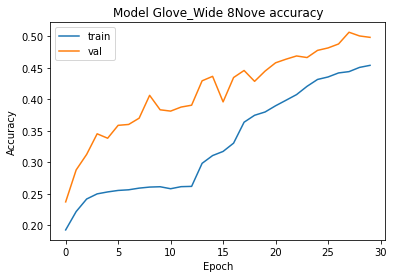

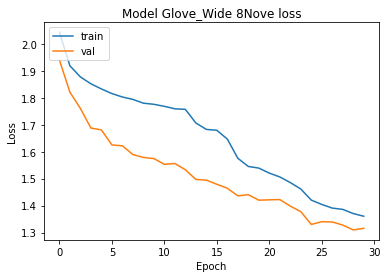

In [ ]:
plt.plot(hist_glove_new_wide.history['accuracy'])
plt.plot(hist_glove_new_wide.history['val_accuracy'])
plt.title('Model Glove_Wide 8Nove accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_new_wide.history['loss'])
plt.plot(hist_glove_new_wide.history['val_loss'])
plt.title('Model Glove_Wide 8Nove loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred_glove_new_wide = model_glove_new_wide.predict(test_padded_new)
sample_submission_new[['0','1','2','3','4','5','6','7']] = pred_glove_new_wide
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,0.233701,0.101223,0.007502,0.004039,0.013262,0.298232,3.218981e-03,0.338822
1,1,0.225494,0.103773,0.012034,0.006532,0.018780,0.303036,5.837300e-03,0.324514
2,2,0.263890,0.085021,0.000678,0.000338,0.002253,0.252683,1.584233e-04,0.394979
3,3,0.258821,0.088645,0.001124,0.000567,0.003277,0.262442,2.980187e-04,0.384826
4,4,0.209753,0.105402,0.023767,0.013052,0.030810,0.304543,1.382448e-02,0.298849
...,...,...,...,...,...,...,...,...,...
27313,27313,0.597874,0.399659,0.000180,0.000277,0.001334,0.000019,2.396208e-09,0.000657
27314,27314,0.068050,0.021483,0.243693,0.034834,0.186231,0.024011,3.544802e-01,0.067219
27315,27315,0.501480,0.487091,0.001596,0.002656,0.006766,0.000014,2.549001e-08,0.000397
27316,27316,0.698988,0.265148,0.000982,0.000744,0.004311,0.003098,2.070590e-06,0.026726


In [ ]:
model_glove_new_wide.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_glove_new_wide.h5')

### 4.2.4. CNN Result

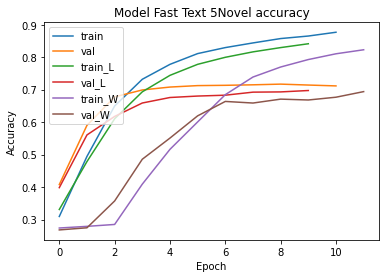

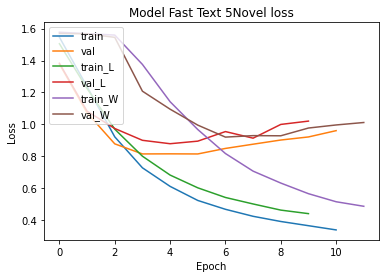

In [ ]:
plt.plot(hist_fast_org.history['accuracy'])
plt.plot(hist_fast_org.history['val_accuracy'])
plt.plot(hist_fast_org_long.history['accuracy'])
plt.plot(hist_fast_org_long.history['val_accuracy'])
plt.plot(hist_fast_org_wide.history['accuracy'])
plt.plot(hist_fast_org_wide.history['val_accuracy'])
plt.title('Model Fast Text 5Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val','train_L','val_L','train_W','val_W'], loc='upper left')
plt.show()

plt.plot(hist_fast_org.history['loss'])
plt.plot(hist_fast_org.history['val_loss'])
plt.plot(hist_fast_org_long.history['loss'])
plt.plot(hist_fast_org_long.history['val_loss'])
plt.plot(hist_fast_org_wide.history['loss'])
plt.plot(hist_fast_org_wide.history['val_loss'])
plt.title('Model Fast Text 5Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val','train_L','val_L','train_W','val_W'], loc='upper left')
plt.show()


General-CNN 모델 FastText 5Novel
1372/1372 - 63s - loss: 0.3401 - accuracy: 0.8768 - val_loss: 0.9611 - val_accuracy: 0.7116<br><br>
Long-CNN 모델 FastText 5Novel
1372/1372 - 62s - loss: 0.4420 - accuracy: 0.8413 - val_loss: 1.0208 - val_accuracy: 0.6973<br><br>
Wide-CNN 모델 FastText 5Novel
1372/1372 - 68s - loss: 0.4880 - accuracy: 0.8228 - val_loss: 1.0121 - val_accuracy: 0.6940

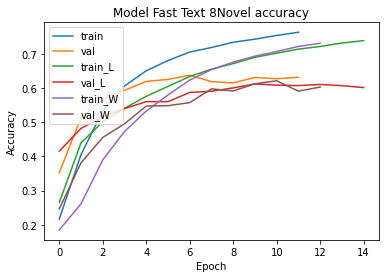

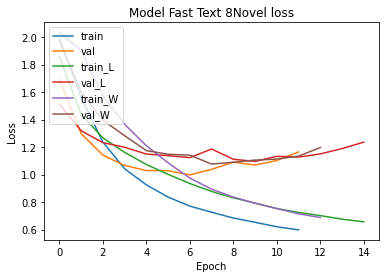

In [ ]:
plt.plot(hist_fast_new.history['accuracy'])
plt.plot(hist_fast_new.history['val_accuracy'])
plt.plot(hist_fast_new_long.history['accuracy'])
plt.plot(hist_fast_new_long.history['val_accuracy'])
plt.plot(hist_fast_new_wide.history['accuracy'])
plt.plot(hist_fast_new_wide.history['val_accuracy'])
plt.title('Model Fast Text 8Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val','train_L','val_L','train_W','val_W'], loc='upper left')
plt.show()

plt.plot(hist_fast_new.history['loss'])
plt.plot(hist_fast_new.history['val_loss'])
plt.plot(hist_fast_new_long.history['loss'])
plt.plot(hist_fast_new_long.history['val_loss'])
plt.plot(hist_fast_new_wide.history['loss'])
plt.plot(hist_fast_new_wide.history['val_loss'])
plt.title('Model Fast Text 8Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val','train_L','val_L','train_W','val_W'], loc='upper left')
plt.show()


General-CNN 모델 FastText 8Novel
2081/2081 - 126s - loss: 0.5977 - accuracy: 0.7627 - val_loss: 1.1648 - val_accuracy: 0.6312<br><br>
Long-CNN 모델 FastText 8Novel
2081/2081 - 130s - loss: 0.6561 - accuracy: 0.7382 - val_loss: 1.2359 - val_accuracy: 0.6010<br><br>
Wide-CNN 모델 FastText 8Novel
2081/2081 - 129s - loss: 0.6876 - accuracy: 0.7305 - val_loss: 1.1966 - val_accuracy: 0.6025

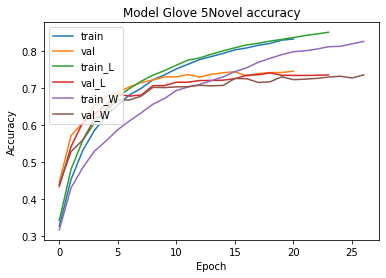

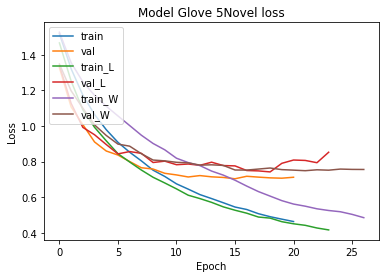

In [ ]:
plt.plot(hist_glove_org.history['accuracy'])
plt.plot(hist_glove_org.history['val_accuracy'])
plt.plot(hist_glove_org_long.history['accuracy'])
plt.plot(hist_glove_org_long.history['val_accuracy'])
plt.plot(hist_glove_org_wide.history['accuracy'])
plt.plot(hist_glove_org_wide.history['val_accuracy'])
plt.title('Model Glove 5Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val','train_L','val_L','train_W','val_W'], loc='upper left')
plt.show()

plt.plot(hist_glove_org.history['loss'])
plt.plot(hist_glove_org.history['val_loss'])
plt.plot(hist_glove_org_long.history['loss'])
plt.plot(hist_glove_org_long.history['val_loss'])
plt.plot(hist_glove_org_wide.history['loss'])
plt.plot(hist_glove_org_wide.history['val_loss'])
plt.title('Model Glove 5Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val','train_L','val_L','train_W','val_W'], loc='upper left')
plt.show()


General-CNN 모델 Glove 5Novel
1372/1372 - 34s - loss: 0.4629 - accuracy: 0.8326 - val_loss: 0.7119 - val_accuracy: 0.7456<br><br>
Long-CNN 모델 Glove 5Novel
1372/1372 - 33s - loss: 0.4157 - accuracy: 0.8509 - val_loss: 0.8526 - val_accuracy: 0.7358<br><br>
Wide-CNN 모델 Glove 5Novel
1372/1372 - 34s - loss: 0.4846 - accuracy: 0.8261 - val_loss: 0.7557 - val_accuracy: 0.7356

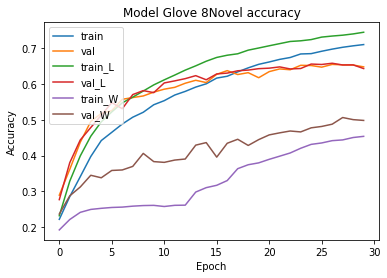

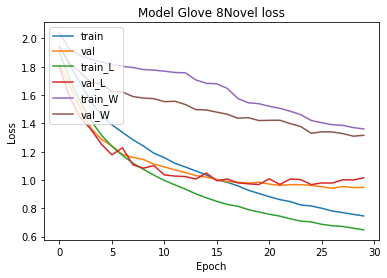

In [ ]:
plt.plot(hist_glove_new.history['accuracy'])
plt.plot(hist_glove_new.history['val_accuracy'])
plt.plot(hist_glove_new_long.history['accuracy'])
plt.plot(hist_glove_new_long.history['val_accuracy'])
plt.plot(hist_glove_new_wide.history['accuracy'])
plt.plot(hist_glove_new_wide.history['val_accuracy'])
plt.title('Model Glove 8Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val','train_L','val_L','train_W','val_W'], loc='upper left')
plt.show()

plt.plot(hist_glove_new.history['loss'])
plt.plot(hist_glove_new.history['val_loss'])
plt.plot(hist_glove_new_long.history['loss'])
plt.plot(hist_glove_new_long.history['val_loss'])
plt.plot(hist_glove_new_wide.history['loss'])
plt.plot(hist_glove_new_wide.history['val_loss'])
plt.title('Model Glove 8Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val','train_L','val_L','train_W','val_W'], loc='upper left')
plt.show()


General-CNN 모델 Glove 8Novel
2081/2081 - 63s - loss: 0.7460 - accuracy: 0.7102 - val_loss: 0.9482 - val_accuracy: 0.6480<br><br>
Long-CNN 모델 Glove 8Novel
2081/2081 - 61s - loss: 0.6474 - accuracy: 0.7447 - val_loss: 1.0153 - val_accuracy: 0.6432<br><br>
Wide-CNN 모델 Glove 8Novel
2081/2081 - 65s - loss: 1.4216 - accuracy: 0.4258 - val_loss: 1.3462 - val_accuracy: 0.4640

### 4.2.5. Conclusion
멋쟁이사자처럼 인공지능 교육에서 배운 자연어 CNN모델을 기반으로 진행했으며,
관련 논문을 검색해보니 교육 받은 CNN모델이 뉴욕대학의 김윤 교수님이 2017년에 발표하신 논문이라는 것을 알았으며, 초기에 배운 일직선으로 이루어진 convolutional layer와 달리 1층에 convolutional layer가 넓게 펼쳐져 있다 모이는 형태를 보이는데 그렇다면 초기에 배운 일직선으로 이루어진 형태 모델과 기본 자연어 CNN모델보다 조금더 넓은 형태의 모델중 어떤것이 더 좋은 정확도를 가지게 될 것인지 궁금해서 총 3가지의 기본 자연어 CNN, Long 자연어 CNN, Wide 자연어 CNN으로 학습을 진행해 보았습니다.
<br><br>

학습을 진행해본 결과 5명의 작가를 구분하는 모델의 정확도가 8명을 구분하는 모델 보다 평균 10%정도 높다는 것 알 수있었고 FastText 임베딩을 활용한 모델의 경우 기본 자연어 CNN 모델의 정확도가 다른 두 모델보다 높다는 것을 확인했습니다. 하지만 Glove 임베딩을 활용한 모델의 경우 Long 자연어 CNN 모델이
제일 높은 정확도를 보이는것을 확인했습니다. 조금더 연구를 해봐야 하는 부분이지만 임베딩 모델에 따라서 CNN 모델의 형태가 달라지는것이 정확도를 올리는 것에 어느정도는 영향이 있지 않나 생각이 들었습니다.
<br><br>

조금 더 시간이 주워진다면 김윤 교수님이 왜 넓은 형태의 레이어를 쌓았는지 찾아보면서 임베딩 모델과 CNN 레이어의 형태의 상관관계에 대해 연구하면 좋을것 같다는 생각이 들었고 그리고 상관관계의 연구를 통해 각 임베딩 모델의 최적화된 CNN 레이어 형태를 만들어 보면 좋을것 같습니다.

## 4.3. LSTM(Long Short-Term Memory)

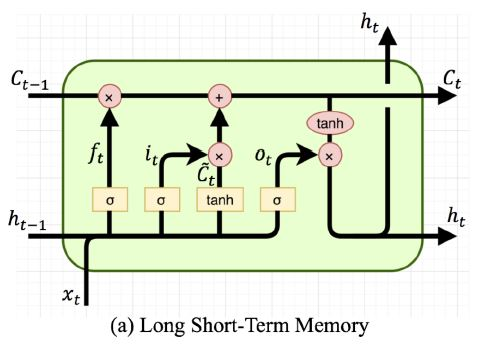

C값 은 cell state라고 하며 LSTM은 이 cell state를 보호하고 컨트롤 하기 위한 세 가지 게이트 : forget, input, output gate 를 통해 기울기 소실을 방지하고 기울기가 효과적으로 흐를 수 있게 해줍니다.

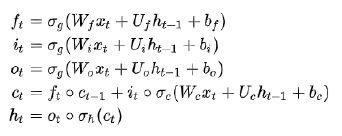

forget gate $f_t$는 말그대로 ‘과거 정보를 잊기’위한 게이트입니다. 시그모이드 함수의 출력 범위는 0 ~ 1 이기 때문에 그 값이 0이라면 이전 상태의 정보는 잊고, 1이라면 이전 상태의 정보를 온전히 기억하게 됩니다.

input gate $i_t$는 ‘현재 정보를 기억하기’위한 게이트입니다. 이 값은 시그모이드 이므로 0 ~ 1 이지만 hadamard product를 하는 $C_t$는 tan(h)(hyperbolic tangent) 결과이므로 -1 ~ 1이 됩니다. 따라서 결과는 음수가 될 수도 있습니다.

output gate $o_t$는 최종 결과 $h_t$를 위한 게이트이며, cell state의 tanh(hyperbolic tangent)를 hadamard product한 값이 LSTM의 최종 결과가 됩니다.

hadamard product : 같은 크기의 두 행렬의 각 성분을 곱하는 연산입니다.


### 4.3.1. Fasttext 활용


#### 4.3.1.1. unit 30개 활용

In [ ]:
model_FT_lstm_30 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100,weights = [FT_embedding_matrix] ,input_length=max_length),
    tf.keras.layers.LSTM(units=30),
    
    tf.keras.layers.Dense(8, activation='softmax')
])

# compile model
model_FT_lstm_30.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_FT_lstm_30.summary())

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, 
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)
# fit model
num_epochs = 20
history = model_FT_lstm_30.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, batch_size = 256,
                    validation_split=0.2, callbacks = [early_stopping])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 212, 100)          6316200   
_________________________________________________________________
lstm_13 (LSTM)               (None, 30)                15720     
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 248       
Total params: 6,332,168
Trainable params: 6,332,168
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
260/260 - 22s - loss: 2.0415 - accuracy: 0.1784 - val_loss: 2.0355 - val_accuracy: 0.1857
Epoch 2/20
260/260 - 21s - loss: 2.0388 - accuracy: 0.1810 - val_loss: 2.0349 - val_accuracy: 0.1866
Epoch 3/20
260/260 - 21s - loss: 2.0373 - accuracy: 0.1815 - val_loss: 2.0339 - val_accuracy: 0.1873
Epoch 4/20
260/260 - 20s - loss: 2.0353 - accuracy: 0.1829 - val_l

#### 4.3.1.2. unit 50개 활용

In [ ]:
model_FT_lstm_50 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100,weights = [FT_embedding_matrix] ,input_length=max_length),
    tf.keras.layers.LSTM(units=50),
    
    tf.keras.layers.Dense(8, activation='softmax')
])

# compile model
model_FT_lstm_50.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_FT_lstm_50.summary())

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, 
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)
# fit model
num_epochs = 20
history = model_FT_lstm_50.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, batch_size = 256,
                    validation_split=0.2, callbacks = [early_stopping])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 212, 100)          6316200   
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 408       
Total params: 6,346,808
Trainable params: 6,346,808
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
260/260 - 23s - loss: 2.0416 - accuracy: 0.1803 - val_loss: 2.0373 - val_accuracy: 0.1860
Epoch 2/20
260/260 - 20s - loss: 2.0386 - accuracy: 0.1812 - val_loss: 2.0370 - val_accuracy: 0.1854
Epoch 3/20
260/260 - 20s - loss: 2.0379 - accuracy: 0.1813 - val_loss: 2.0340 - val_accuracy: 0.1867
Epoch 4/20
260/260 - 20s - loss: 2.0353 - accuracy: 0.1820 - val_

#### 4.3.1.3. unit 128개 활용

In [ ]:
model_FT_lstm_128 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100,weights = [FT_embedding_matrix] ,input_length=max_length),
    tf.keras.layers.LSTM(units=128),
    tf.keras.layers.Dense(8, activation='softmax')
])

# compile model
model_FT_lstm_128.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_FT_lstm_128.summary())

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, 
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)
# fit model
num_epochs = 1000
history = model_FT_lstm_128.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, batch_size = 256,
                    validation_split=0.2, callbacks = [early_stopping])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 212, 100)          6316200   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
Total params: 6,434,480
Trainable params: 6,434,480
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
260/260 - 58s - loss: 2.0455 - accuracy: 0.1789 - val_loss: 2.0371 - val_accuracy: 0.1852
Epoch 2/1000
260/260 - 28s - loss: 2.0400 - accuracy: 0.1805 - val_loss: 2.0382 - val_accuracy: 0.1854
Epoch 3/1000
260/260 - 28s - loss: 2.0381 - accuracy: 0.1807 - val_loss: 2.0337 - val_accuracy: 0.1864
Epoch 4/1000
260/260 - 25s - loss: 1.9994 - accuracy: 0.1911 -

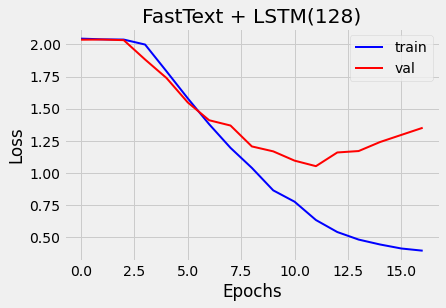

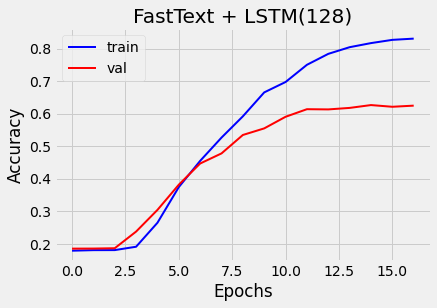

In [ ]:
import matplotlib.pyplot as plt


def plot_model_perfomance(history,name):
    plt.style.use('fivethirtyeight')
    plt.figure(1)
    plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.figure(2)
    plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

plot_model_perfomance(history,'FastText + LSTM(128)')

        1. 첫번째 실험
        unit 수를 늘리면 성능이 올라갈까?
        unit128일 경우에 가장 성능이 좋았으나 val_loss, val_acc의 성능이 train과 차이가 많이 남

        번외)
        batch수를 1024, 512, 256, 64 등으로 맞춰서 진행해본 결과 batch수가 너무 클 경우 학습이 금방끝났지만 성능이 좋지 못했고,
        batch가 작을 경우 시간이 오래걸렸으나 batch수가 큰 경우보다 약간의 성능이 높았다.
        이번 실험에서는 256을 사용하여 실험을 해보았다.

        adam / batch 256 / val_split 0.2 / unit 30,50,128

#### 4.3.1.4. LSTM-CNN 활용

In [ ]:
model_FT_lstm_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100,weights = [FT_embedding_matrix] ,input_length=max_length),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2, padding="same"),
    tf.keras.layers.LSTM(units=128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='softmax')
])


# compile model
model_FT_lstm_cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_FT_lstm_cnn.summary())

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=7 ,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)
# fit model
num_epochs = 100
history = model_FT_lstm_cnn.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, batch_size = 64,
                    validation_split=0.2, callbacks = [early_stopping])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 212, 100)          6316200   
_________________________________________________________________
conv1d (Conv1D)              (None, 212, 128)          38528     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 106, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total params: 6,487,344
Trainable params: 6,487,344
Non-trainable params: 0
____________________________________________

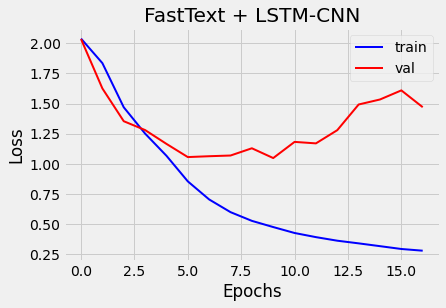

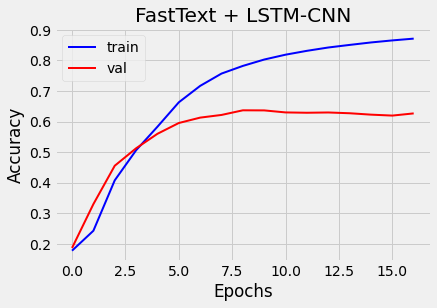

In [ ]:
import matplotlib.pyplot as plt


def plot_model_perfomance(history,name):
    plt.style.use('fivethirtyeight')
    plt.figure(1)
    plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.figure(2)
    plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

plot_model_perfomance(history,'FastText + LSTM-CNN')

        LSTM-CNN모델

        Embedding > conv > maxpooling> LSTM > Dropout > Dense

        adam / FastText / batch = 64 / dropout = 0.5 / filter = 128
    

        단일층의 unit 128모델과 비교했을때, acc는 약 3% 오르고 loss는 10 % 줄어든 성능을 보였다.
        하지만 val_loss의 경우 unit128보다 높으며 train과 성능 차이가 좀 더 났음을 확인했다.

        아 그렇다면 CNN의 츨을 높인다면 어떨까? 실험해보았지만 성능이 좋지않아 결과에서 제외시켰습니다. (논문과 별개로 개인적인 실험)

### 4.3.2. Glove 활용

#### 4.3.2.1. unit 30개 활용

In [ ]:
model_G_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 50,weights = [glove_embedding_matrix] ,input_length=max_length),

    tf.keras.layers.LSTM(units=30),

    tf.keras.layers.Dense(8, activation='softmax')
])

# compile model
model_G_lstm.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_G_lstm.summary())


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, 
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)
# fit model
num_epochs = 30
history = model_G_lstm.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, batch_size = 256,
                    validation_split=0.2, callbacks = [early_stopping])

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 212, 50)           3158150   
_________________________________________________________________
lstm_29 (LSTM)               (None, 30)                9720      
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 248       
Total params: 3,168,118
Trainable params: 3,168,118
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
260/260 - 13s - loss: 2.0428 - accuracy: 0.1797 - val_loss: 2.0382 - val_accuracy: 0.1850
Epoch 2/30
260/260 - 11s - loss: 2.0403 - accuracy: 0.1802 - val_loss: 2.0375 - val_accuracy: 0.1852
Epoch 3/30
260/260 - 11s - loss: 2.0394 - accuracy: 0.1801 - val_loss: 2.0336 - val_accuracy: 0.1867
Epoch 4/30
260/260 - 11s - loss: 2.0364 - accuracy: 0.1816 - val_

unit 50

In [ ]:
model_G_lstm_50 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 50,weights = [glove_embedding_matrix] ,input_length=max_length),

    tf.keras.layers.LSTM(units=50),

    tf.keras.layers.Dense(8, activation='softmax')
])

# compile model
model_G_lstm_50.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_G_lstm_50.summary())


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

# fit model
num_epochs = 20
history = model_G_lstm_50.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2,batch_size = 256,
                    validation_split=0.2, callbacks = [early_stopping])

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 212, 50)           3158150   
_________________________________________________________________
lstm_31 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 408       
Total params: 3,178,758
Trainable params: 3,178,758
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
260/260 - 13s - loss: 2.0420 - accuracy: 0.1794 - val_loss: 2.0376 - val_accuracy: 0.1851
Epoch 2/20
260/260 - 10s - loss: 2.0407 - accuracy: 0.1800 - val_loss: 2.0372 - val_accuracy: 0.1852
Epoch 3/20
260/260 - 10s - loss: 2.0390 - accuracy: 0.1806 - val_loss: 2.0332 - val_accuracy: 0.1861
Epoch 4/20
260/260 - 10s - loss: 1.9654 - accuracy: 0.2037 - val_

unit 128

In [ ]:
model_G_lstm_128 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 50,weights = [glove_embedding_matrix] ,input_length=max_length),
    tf.keras.layers.LSTM(units=128),
    tf.keras.layers.Dense(8, activation='softmax')
])

# compile model
model_G_lstm_128.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_G_lstm_128.summary())

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, 
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)
# fit model
num_epochs = 1000
history = model_G_lstm_128.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, batch_size = 256,
                    validation_split=0.2, callbacks = [early_stopping])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 212, 50)           3158150   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total params: 3,250,830
Trainable params: 3,250,830
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
260/260 - 18s - loss: 2.0487 - accuracy: 0.1776 - val_loss: 2.0373 - val_accuracy: 0.1852
Epoch 2/1000
260/260 - 18s - loss: 2.0475 - accuracy: 0.1802 - val_loss: 2.0378 - val_accuracy: 0.1850
Epoch 3/1000
260/260 - 19s - loss: 2.0404 - accuracy: 0.1796 - val_loss: 2.0378 - val_accuracy: 0.1851
Epoch 4/1000
260/260 - 19s - loss: 2.0401 - accuracy: 0.1803

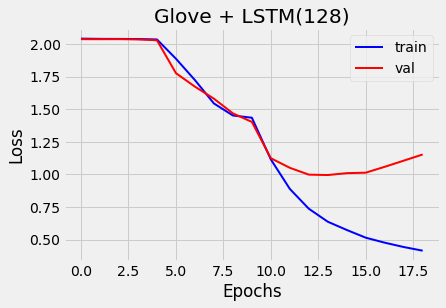

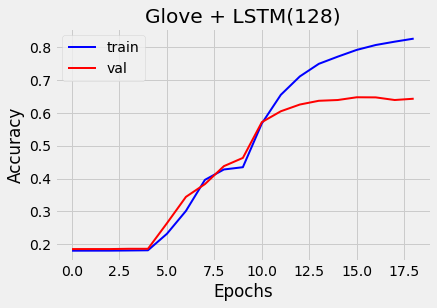

In [ ]:
#에포크에 따른 loss와 accuracy 변화 그래프
def plot_model_perfomance(history,name):
    plt.style.use('fivethirtyeight')
    plt.figure(1)

    plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.figure(2)

    plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

plot_model_perfomance(history,'Glove + LSTM(128)')

    1. 첫번째 실험
    unit 수를 늘리면 성능이 올라갈까?
    FastText와 마찬가지로 Glove 임베딩을 사용한 단일층 unit128일 경우에 82.6%로 가장 성능이 좋았다
    하지만 여기서도 val_loss, val_acc의 성능이 train과 차이가 많이 났음을 알 수 있다.
 
 
    adam / batch 256 / val_split 0.2 / unit 30,50,128

#### 4.3.2.2. LSTM-CNN 활용

In [ ]:
model_FT_lstm_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 50,weights = [glove_embedding_matrix] ,input_length=max_length),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2, padding="same"),
    tf.keras.layers.LSTM(units=128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='softmax')
])


# compile model
model_FT_lstm_2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_FT_lstm_2.summary())

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=7 ,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)
# fit model
num_epochs = 100
history = model_FT_lstm_2.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, batch_size = 64,
                    validation_split=0.2, callbacks = [early_stopping])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 212, 50)           3158150   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 212, 128)          19328     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 106, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1032      
Total params: 3,310,094
Trainable params: 3,310,094
Non-trainable params: 0
____________________________________________

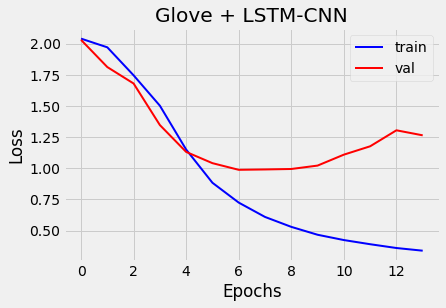

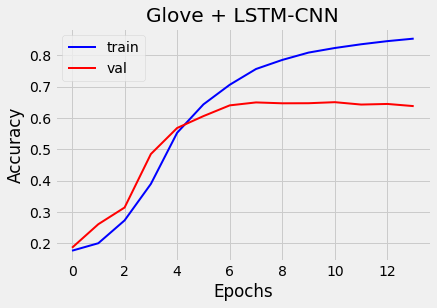

In [ ]:
def plot_model_perfomance(history,name):
    plt.style.use('fivethirtyeight')
    plt.figure(1)

    plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.figure(2)

    plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

plot_model_perfomance(history,'Glove + LSTM-CNN')

        LSTM-CNN모델

        Embedding > conv > maxpooling> LSTM > Dropout > Dense

        adam / FastText / batch = 64 / dropout = 0.5 / filter = 128
    

        단일층의 unit 128모델과 비교했을때, acc는 약 3% 오르고 loss는 8 % 줄어든 성능을 보였다.
        하지만 val_loss의 경우 unit128보다 높았으며, train과 성능 차이가 좀 더 났음을 확인했다.



        결국 LSTM-CNN 모델의 성능이 좋았는데
        이번 결과에서는 FastText를 사용하는게 acc와 loss 측면에서 더 좋은 결과를 얻었다.
        (acc=87%, loss=28%)

        하지만 validation과의 차이가 좀 있기 때문에 줄일수 있는 방법을 강구해야할 것 같다.
        하이퍼 파라미터의 조정, 층을 늘리기, 다른 모델과의 결합등을 고려해서 실험해볼 수 있을 것 같다.


### 4.3.3. LSTM Result

In [ ]:
sample_submission

,Unnamed: 0,index,0,1,2,3,4,5,6,7
0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0
2,2,2,0,0,0,0,0,0,0,0
3,3,3,0,0,0,0,0,0,0,0
4,4,4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
27313,27313,27313,0,0,0,0,0,0,0,0
27314,27314,27314,0,0,0,0,0,0,0,0
27315,27315,27315,0,0,0,0,0,0,0,0
27316,27316,27316,0,0,0,0,0,0,0,0


In [ ]:
pred_FT_128 = model_FT_lstm_128.predict(test_padded)
pred_FT_128

array([[7.1802796e-03, 5.9519794e-02, 1.0558590e-02, ..., 6.8579817e-01,
        1.8825267e-01, 1.3612258e-02],
       [3.4382206e-04, 4.2951632e-02, 5.0385419e-04, ..., 9.5343834e-01,
        8.1937597e-04, 1.5186310e-03],
       [2.1104661e-03, 2.4650526e-01, 1.3975509e-03, ..., 7.4528551e-01,
        3.6738114e-04, 2.3646562e-03],
       ...,
       [7.9944311e-03, 9.8469824e-01, 4.4701676e-04, ..., 3.6994424e-03,
        2.8827869e-06, 6.4790656e-05],
       [7.9357978e-03, 9.8449928e-01, 4.6248146e-04, ..., 3.7465072e-03,
        3.0600108e-06, 6.5168613e-05],
       [1.0862062e-02, 5.0930289e-06, 2.6215479e-05, ..., 7.7429868e-06,
        1.8635967e-04, 9.8884881e-01]], dtype=float32)

In [ ]:
len(pred_FT_128)

27318

In [ ]:
sample_submission[['0','1','2','3','4','5','6','7']] = pred_FT_128
sample_submission.to_csv('submission_FT_128.csv', index = False)

In [ ]:
pred_FT_cnn = model_FT_lstm_cnn.predict(test_padded)
pred_FT_cnn

array([[3.3333901e-02, 1.0812887e-01, 4.4248659e-02, ..., 2.8458515e-01,
        2.4149300e-01, 1.1512893e-01],
       [5.2333800e-03, 1.2624253e-01, 9.4579160e-02, ..., 2.7886689e-01,
        2.8084314e-01, 4.3254856e-02],
       [7.2327536e-04, 2.4251144e-01, 1.0800808e-03, ..., 7.5186402e-01,
        8.7356434e-04, 1.9605558e-03],
       ...,
       [5.1681004e-03, 9.9203217e-01, 6.9521158e-04, ..., 1.2658454e-03,
        1.6840557e-05, 4.1827156e-05],
       [1.0851536e-02, 9.8607630e-01, 1.0942775e-03, ..., 7.2759268e-04,
        1.9158884e-05, 5.7271769e-05],
       [4.1877840e-02, 1.5277258e-03, 1.5737818e-03, ..., 3.0353931e-03,
        1.4939275e-02, 9.3383074e-01]], dtype=float32)

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/new_sample_submission.csv', encoding = 'utf-8')

In [ ]:
sample_submission[['0','1','2','3','4','5','6','7']] = pred_FT_cnn
sample_submission.to_csv('submission_FT_cnn.csv', index = False)

In [ ]:
pred_G_128 = model_G_lstm_128.predict(test_padded)
pred_G_128

array([[0.01750951, 0.09280887, 0.0298206 , ..., 0.3438935 , 0.42461947,
        0.02314765],
       [0.1554916 , 0.0861906 , 0.1352335 , ..., 0.08800144, 0.10384267,
        0.15995173],
       [0.15549092, 0.0861913 , 0.1352333 , ..., 0.08800189, 0.10384335,
        0.1599511 ],
       ...,
       [0.15549092, 0.0861913 , 0.1352333 , ..., 0.08800189, 0.10384335,
        0.1599511 ],
       [0.15549092, 0.0861913 , 0.1352333 , ..., 0.08800189, 0.10384335,
        0.1599511 ],
       [0.15549092, 0.0861913 , 0.1352333 , ..., 0.08800189, 0.10384335,
        0.1599511 ]], dtype=float32)

In [ ]:
sample_submission[['0','1','2','3','4','5','6','7']] = pred_G_128
sample_submission.to_csv('submission_G_128.csv', index = False)

In [ ]:
pred_G_cnn = model_FT_lstm_2.predict(test_padded)
pred_G_cnn

array([[4.1665707e-02, 2.4673013e-01, 8.4210090e-02, ..., 3.9300770e-01,
        8.9864232e-02, 3.2006562e-02],
       [9.2443719e-04, 3.3385196e-01, 5.5370590e-04, ..., 6.6116250e-01,
        1.2769245e-03, 1.6869067e-03],
       [1.7114145e-03, 4.9232084e-01, 1.4868027e-03, ..., 4.9536091e-01,
        4.9755634e-03, 3.0130665e-03],
       ...,
       [3.1380146e-03, 9.9454749e-01, 6.3926727e-04, ..., 9.7871339e-04,
        4.9235401e-05, 7.8142129e-06],
       [2.5092922e-03, 9.9515641e-01, 7.0697861e-04, ..., 9.8816084e-04,
        6.1592327e-05, 6.7113015e-06],
       [4.5687139e-01, 8.6204219e-04, 7.6862925e-04, ..., 2.9795588e-04,
        4.6375368e-04, 5.3314763e-01]], dtype=float32)

In [ ]:
sample_submission[['0','1','2','3','4','5','6','7']] = pred_G_cnn
sample_submission.to_csv('submission_G_cnn.csv', index = False)

## 4.4. Bi-LSTM(Bidirectional LSTM)

### 4.4.1. 기본 Bi-LSTM

#### 4.4.1.1. 임베딩 적용 없는 2-Layer Bi-LSTM

In [ ]:
# loss감소가 10번 이상 미발생이면 stop
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode = 'min', patience=5, verbose=1)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64,return_sequences=True,dropout=0.5)),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [ ]:
# compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

# model summary
print(model.summary())


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 500, 16)           1019648   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 500, 128)          41472     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1032      
Total params: 1,160,968
Trainable params: 1,160,968
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# fit model
num_epochs = 30
history = model.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2, callbacks = [earlystopper])

#### 4.4.1.2. Fasttext 활용 2-Layer Bi-LSTM

In [ ]:
model_using_FT = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, weights = [FT_embedding_matrix] ,input_length=max_length),
    Bidirectional(LSTM(64,return_sequences=True,dropout=0.5)),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [ ]:
# compile model
model_using_FT.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_using_FT.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 500, 100)          6372800   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 500, 128)          84480     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 1032      
Total params: 6,557,128
Trainable params: 6,557,128
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# fit model
num_epochs = 30
history = model_using_FT.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2, callbacks = [earlystopper])

#### 4.4.1.3. Glove 활용 2-Layer Bi-LSTM

In [ ]:
model_using_Glove = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 50,weights = [embedding_matrix] ,input_length=max_length),
    Bidirectional(LSTM(64,return_sequences=True,dropout=0.5)),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [ ]:
# compile model
model_using_Glove.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_using_Glove.summary())


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 500, 50)           3186400   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 500, 128)          58880     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 1032      
Total params: 3,345,128
Trainable params: 3,345,128
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# fit model
num_epochs = 30
history = model_using_Glove.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2, callbacks = [earlystopper])

### 4.4.2. Attention Mechanism 적용 Bi-LSTM

#### 4.4.2.1. 임베딩 적용 없는 2-Layer Bi-LSTM

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64,return_sequences=True,dropout=0.3)),
    Dropout(0.5),
    Attention(32),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [ ]:
# compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

# model summary
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 16)           1019648   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 500, 128)          41472     
_________________________________________________________________
dropout_9 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
last_hidden_state (Lambda)   (None, 128)               0         
_________________________________________________________________
attention_score_vec (Dense)  (None, 500, 128)          16384     
_________________________________________________________________
attention_score (Dot)        (None, 500)               0         
_________________________________________________________________
attention_weight (Activation (None, 500)              

In [ ]:
# fit model
num_epochs = 30
history = model.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2, callbacks = [earlystopper])

#### 4.4.2.2. Fasttext 활용 2-Layer Bi-LSTM

In [ ]:
#가벼운 NLP모델 생성(Using FastText)
model_using_FT = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, weights = [FT_embedding_matrix] ,input_length=max_length),
    Bidirectional(LSTM(64,return_sequences=True,dropout=0.3)),
    Dropout(0.5),
    Attention(32),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [ ]:
# compile model
model_using_FT.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_using_FT.summary())


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 100)          6372800   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 500, 128)          84480     
_________________________________________________________________
dropout_10 (Dropout)         (None, 500, 128)          0         
_________________________________________________________________
last_hidden_state (Lambda)   (None, 128)               0         
_________________________________________________________________
attention_score_vec (Dense)  (None, 500, 128)          16384     
_________________________________________________________________
attention_score (Dot)        (None, 500)               0         
_________________________________________________________________
attention_weight (Activation (None, 500)             

In [ ]:
# fit model
num_epochs = 30
history = model_using_FT.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2, callbacks = [earlystopper])

#### 4.4.2.3. Glove 활용 2-Layer Bi-LSTM

In [ ]:
model_using_Glove = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 50,weights = [embedding_matrix] ,input_length=max_length),
    Bidirectional(LSTM(64,return_sequences=True,dropout=0.3)),
    Dropout(0.5),
    Attention(32),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [ ]:
# compile model
model_using_Glove.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_using_Glove.summary())


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 500, 50)           3186400   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 500, 128)          58880     
_________________________________________________________________
dropout_11 (Dropout)         (None, 500, 128)          0         
_________________________________________________________________
last_hidden_state (Lambda)   (None, 128)               0         
_________________________________________________________________
attention_score_vec (Dense)  (None, 500, 128)          16384     
_________________________________________________________________
attention_score (Dot)        (None, 500)               0         
_________________________________________________________________
attention_weight (Activation (None, 500)             

In [ ]:
# fit model
num_epochs = 30
history = model_using_Glove.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2, callbacks = [earlystopper])

### 4.4.3. Bi-LSTM Result

In [ ]:
# predict values
pred = model_using_FT.predict_proba(test_padded)

In [ ]:
pred

In [ ]:
# submission
sample_submission[['0','1','2','3','4']] = pred
sample_submission

,index,0,1,2,3,4
0,0,0.244451,0.130629,0.211542,0.27031,0.143069
1,1,0.244451,0.130629,0.211542,0.27031,0.143069
2,2,0.244451,0.130629,0.211542,0.27031,0.143069
3,3,0.244451,0.130629,0.211542,0.27031,0.143069
4,4,0.244451,0.130629,0.211542,0.27031,0.143069
...,...,...,...,...,...,...
19612,19612,0.244451,0.130629,0.211542,0.27031,0.143069
19613,19613,0.244451,0.130629,0.211542,0.27031,0.143069
19614,19614,0.244451,0.130629,0.211542,0.27031,0.143069
19615,19615,0.244451,0.130629,0.211542,0.27031,0.143069


In [ ]:
sample_submission.to_csv('/content/drive/MyDrive/Novelist_Classification/datasets/submission.csv', index = False, encoding = 'utf-8')

## 4.5. GRU(Gated Recurrent Unit)

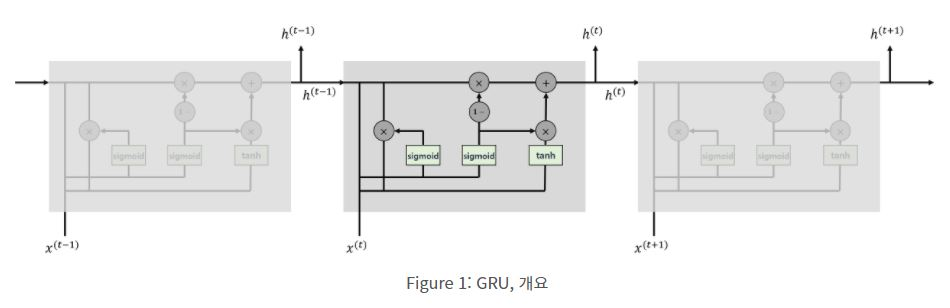

GRU는 Reset gate, Update gate, Candidate, Hidden layer로 구성되어 있다. LSTM의 간소화 버전이라고 할 수 있다. GRU 셀에서 각 출력하는 결과 수식은 다음과 같다.

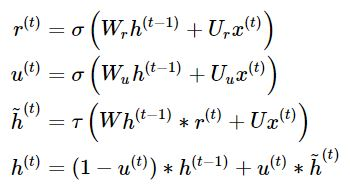

수식을 순서대로 1, 2, 3, 4로 넘버링하여 설명하겠다.
1. 과거의 정보를 적당히 리셋시키는 것을 목표로 sigmoid 함수를 출력으로 이용해 0, 1 값을 가진 은닉 층에 곱해주는 작업이다.
2. 업데이트 게이트를 나타내는 수식이다. LSTM의 forget gate와 input gate를 합쳐놓은 느낌이다. 과거와 현재 정보의 최신화 비율을 결정한다.
3. 후보군을 선정하는 단계이다. 과거 은닉층 정보를 그대로 이용하지 않고 리셋 게이트 결과를 곱해준다.
4. 마지막으로 은닉층 계산 단계이다. 이 단계에서는 update gate 결과와 candidate 결과를 결합하여 현시점의 은닉층을 연산하는 과정이다.

### 4.5.1. 단방향 GRU

#### 4.5.1.1. Fasttext 활용

In [ ]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)


In [ ]:
# 하이퍼파라미터 설정
dropout_prob = 0.8
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size

In [ ]:
# 단방향 GRU - fasttext
from keras.optimizers import Adam
model_using_GRU_fasttext_one = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, 100, weights = [FT_embedding_matrix], input_length=max_length),
  tf.keras.layers.GRU(units=256, activation='tanh'),
  tf.keras.layers.Dropout(dropout_prob),
  tf.keras.layers.Dense(8, activation='softmax'),
])

model_using_GRU_fasttext_one.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_using_GRU_fasttext_one.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 100)          6372700   
_________________________________________________________________
gru_9 (GRU)                  (None, 256)               274944    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 2056      
Total params: 6,649,700
Trainable params: 6,649,700
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 단방향 GRU 학습 - fasttext
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# fit model
num_epochs = 20
hist_fast_gru_one = model_using_GRU_fasttext_one.fit(train_padded, y_train,epochs = num_epochs, verbose = 1, validation_split = 0.2, callbacks = [early_stopping])

Epoch 1/20
2081/2081 [==============================] - 186s 89ms/step - loss: 2.0458 - accuracy: 0.1734 - val_loss: 2.0397 - val_accuracy: 0.1849
Epoch 2/20
2081/2081 [==============================] - 184s 88ms/step - loss: 2.0442 - accuracy: 0.1770 - val_loss: 2.0385 - val_accuracy: 0.1849
Epoch 3/20
2081/2081 [==============================] - 184s 89ms/step - loss: 2.0432 - accuracy: 0.1769 - val_loss: 2.0382 - val_accuracy: 0.1849
Epoch 4/20
2081/2081 [==============================] - 185s 89ms/step - loss: 2.0432 - accuracy: 0.1808 - val_loss: 2.0379 - val_accuracy: 0.1849
Epoch 5/20
2081/2081 [==============================] - 184s 88ms/step - loss: 2.0435 - accuracy: 0.1766 - val_loss: 2.0377 - val_accuracy: 0.1849
Epoch 6/20
2081/2081 [==============================] - 183s 88ms/step - loss: 2.0473 - accuracy: 0.1750 - val_loss: 2.0385 - val_accuracy: 0.1849
Epoch 7/20
2081/2081 [==============================] - 183s 88ms/step - loss: 2.0468 - accuracy: 0.1701 - val_loss: 2

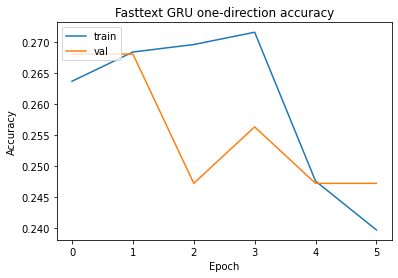

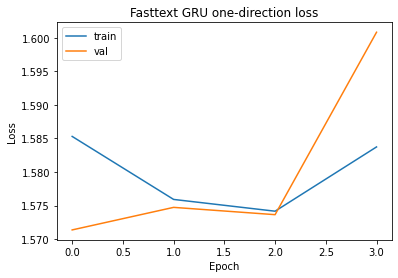

In [ ]:
plt.plot(hist_fast_gru_one.history['accuracy'])
plt.plot(hist_fast_gru_one.history['val_accuracy'])
plt.title('Fasttext GRU one-direction accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_gru_one.history['loss'])
plt.plot(hist_fast_gru_one.history['val_loss'])
plt.title('Fasttext GRU one-direction loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# save GRU
model_using_GRU_fasttext_one.save('/content/drive/MyDrive/Novelist_Classification/model/GRU/gru_fast_one.h5')

#### 4.5.1.2. Glove 활용

In [ ]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size

In [ ]:
# 단방향 GRU - glove
from keras.optimizers import Adam
model_using_GRU_glove_one = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size+1, 50, weights = [g_embedding_matrix], input_length=max_length),
  tf.keras.layers.GRU(units=30), # relu를 활용한 GRU
  tf.keras.layers.Dropout(dropout_prob),
  tf.keras.layers.Dense(8, activation='softmax'),
])

model_using_GRU_glove_one.compile(optimizer = Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_using_GRU_glove_one.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 50)           3186400   
_________________________________________________________________
gru_8 (GRU)                  (None, 30)                7380      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 248       
Total params: 3,194,028
Trainable params: 3,194,028
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 단방향 GRU 학습 - glove
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# fit model
num_epochs = 100
hist_glove_gru_one = model_using_GRU_glove_one.fit(train_padded, y_train, 
                    epochs = num_epochs, verbose = 1,
                    validation_split = 0.2, callbacks = [early_stopping])

Epoch 1/100
2081/2081 [==============================] - 101s 48ms/step - loss: 2.0464 - accuracy: 0.1724 - val_loss: 2.0395 - val_accuracy: 0.1849
Epoch 2/100
2081/2081 [==============================] - 99s 47ms/step - loss: 2.0408 - accuracy: 0.1785 - val_loss: 2.0375 - val_accuracy: 0.1849
Epoch 3/100
2081/2081 [==============================] - 99s 47ms/step - loss: 2.0393 - accuracy: 0.1812 - val_loss: 2.0380 - val_accuracy: 0.1849
Epoch 4/100
2081/2081 [==============================] - 99s 47ms/step - loss: 2.0403 - accuracy: 0.1806 - val_loss: 2.0379 - val_accuracy: 0.1849
Epoch 5/100
2081/2081 [==============================] - 99s 47ms/step - loss: 2.0392 - accuracy: 0.1802 - val_loss: 2.0377 - val_accuracy: 0.1849
Epoch 6/100
2081/2081 [==============================] - 98s 47ms/step - loss: 2.0398 - accuracy: 0.1810 - val_loss: 2.0377 - val_accuracy: 0.1849
Epoch 7/100
2081/2081 [==============================] - 98s 47ms/step - loss: 2.0388 - accuracy: 0.1807 - val_loss: 

In [ ]:
plt.plot(hist_glove_gru_one.history['accuracy'])
plt.plot(hist_glove_gru_one.history['val_accuracy'])
plt.title('Glove GRU one-direction accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_gru_one.history['loss'])
plt.plot(hist_glove_gru_one.history['val_loss'])
plt.title('Glove GRU one-direction loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# save GRU
model_using_GRU_glove_one.save('/content/drive/MyDrive/Novelist_Classification/model/GRU/gru_glove_one.h5')

### 4.5.2. 양방향 GRU

#### 4.5.2.1. Fasttext 활용

In [ ]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size

In [ ]:
# 양방향 GRU - fasttext
from keras.optimizers import Adam
model_using_GRU_fasttext_bi = Sequential([
    Embedding(vocab_size, 100, weights = [FT_embedding_matrix] ,input_length = max_length),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(64)),
    tf.keras.layers.Dropout(dropout_prob),
    Dense(8, activation='softmax')
])
    
model_using_GRU_fasttext_bi.compile(loss='sparse_categorical_crossentropy', optimizer = Adam(learning_rate=0.01))
model_using_GRU_fasttext_bi.summary()

In [ ]:
# 양방향 GRU 학습 - fasttext
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# fit model
num_epochs = 20
hist_fast_gru_bi = model_using_GRU_fasttext_bi.fit(train_padded_, y_train, 
                    epochs = num_epochs, verbose = 1,
                    validation_split = 0.2, callbacks = [early_stopping])

In [ ]:
plt.plot(hist_fast_gru_bi.history['accuracy'])
plt.plot(hist_fast_gru_bi.history['val_accuracy'])
plt.title('Fasttext GRU bi-direction accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_gru_bi.history['loss'])
plt.plot(hist_fast_gru_bi.history['val_loss'])
plt.title('Fasttext GRU bi-direction loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# save GRU
model_using_GRU_fasttext_bi.save('/content/drive/MyDrive/Novelist_Classification/model/GRU/gru_fast_bi.h5')

#### 4.5.2.2. Glove 활용

In [ ]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size
VOCAB_SIZE_new = vocab_size_new

In [ ]:
# 단방향 GRU - glove
from keras.optimizers import Adam
model_using_GRU_glove_bi = Sequential([
    Embedding(vocab_size+1, 50, weights = [g_embedding_matrix] ,input_length = max_length),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(64)),
    tf.keras.layers.Dropout(dropout_prob),
    Dense(8, activation='softmax')
])
    
model_using_GRU_glove_bi.compile(loss='sparse_categorical_crossentropy', optimizer = Adam(learning_rate=0.01))
model_using_GRU_glove_bi.summary()

In [ ]:
# 단방향 GRU 학습 - glove
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# fit model
num_epochs = 20
hist_glove_gru_bi = model_using_GRU_glove_bi.fit(train_padded, y_train, 
                    epochs = num_epochs, verbose = 2,
                    validation_split = 0.2, callbacks = [early_stopping])

In [ ]:
plt.plot(hist_glove_gru_bi.history['accuracy'])
plt.plot(hist_glove_gru_bi.history['val_accuracy'])
plt.title('Glove GRU one-direction accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_gru_bi.history['loss'])
plt.plot(hist_glove_gru_bi.history['val_loss'])
plt.title('Glove GRU one-direction loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# save GRU
model_using_GRU_glove_bi.save('/content/drive/MyDrive/Novelist_Classification/model/GRU/gru_glove_bi.h5')

### 4.5.3. Conclusion
한국인 조경현 교수님이 연구하신 GRU에 대해서 알아보고 적용해보았습니다. 그러나 성능적인 면에서 20%가 넘어가지 않았습니다. 처음에 활성화 함수를 relu와 softmax로 선정했으나 에폭당 시간이 너무 많이 소요되었습니다.<br>
<br>
활성화 함수에 따라서 에폭 당 시간이 현저하게 달라질 수 있다는 것을 깨닫고 이를 보완하고자 GRU의 default 활성화 함수인 tanh를 활용했더니 시간 소요는 3분으로 상당히 줄어들었으나, 정확도를 크게 개선하지는 못했습니다. 일단 20% 미만의 정확도를 보인다는 것은 분명히 무언가 문제가 발생했다는 것인데, 본 실험에서는 해결 방법을 찾지는 못했습니다.<br>
<br>
본 실험에서는 총 4가지만을 확인했습니다. glove를 적용한 단방향 gru, fasttext를 적용한 단방향 gru, glove를 적용한 양방향 gru, fasttext를 적용한 양방향 gru입니다. 결과적으로 전부 20% 미만의 정확도를 보였으므로 이 실험에서 의미있는 결과를 찾지는 못했습니다.

# 5. Reference
- GRU 설명 및 그림 참고 : https://yjjo.tistory.com/18